# Traitement des donnnées

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!pip install gcsfs zarr xarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 70.4 MB/s eta 0:00:00


In [ ]:
import xarray as xr

path = "gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr"

ds = xr.open_zarr(path, storage_options={"token": "cloud"})

ds = ds.assign_coords(
    longitude=((ds.longitude + 180) % 360) - 180
).sortby("longitude")


temp = ds["2m_temperature"]
print(temp)

KeyboardInterrupt: 

In [ ]:
subset = ds["2m_temperature"].sel(
    time=slice('2011-01-01', '2021-12-31'),
    latitude=slice(51.5, 41),
    longitude=slice(-5, 9)
)

print(subset)

In [ ]:
!pip install cartopy

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# --- On sélectionne le premier instant temporel ---
t2m_day1 = subset.isel(time=0)

# --- Extraire lon, lat, data ---
lon = t2m_day1.longitude.values
lat = t2m_day1.latitude.values
data = t2m_day1.values

print("Shapes:", data.shape)

# Vérif 2D
if data.ndim != 2:
    raise RuntimeError("La variable doit être 2D (lat, lon).")

# grille
Lon2d, Lat2d = np.meshgrid(lon, lat)

# --- Tracé ---
fig, ax = plt.subplots(figsize=(9, 7),
                       subplot_kw={"projection": ccrs.PlateCarree()})

# Zone France élargie
ax.set_extent([-5, 9, 41, 51], crs=ccrs.PlateCarree())

# Ajouts géographiques
ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8)
ax.add_feature(cfeature.BORDERS.with_scale("50m"), linewidth=0.6)
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.3)
gl.top_labels = gl.right_labels = False

# Heatmap
cf = ax.contourf(
    Lon2d, Lat2d, data,
    20, cmap="plasma", transform=ccrs.PlateCarree()
)

# Barre de couleur
cbar = fig.colorbar(cf, ax=ax, orientation="vertical", shrink=0.75)
cbar.set_label("Température 2m (K)")

ax.set_title(f"T2M — {str(subset.time.values[0])[:10]} — France")

plt.show()


In [ ]:
import xarray as xr

# ds = ton dataset déjà chargé
# ds = xr.open_zarr("...")  # si tu dois le recharger

# Vérifier que la coordonnée temporelle s'appelle bien "time"
print(subset.time.min().values, subset.time.max().values)

# --- Splits ---
train_ds = subset.sel(time=slice("2011-01-01", "2016-12-31"))
val_ds   = subset.sel(time=slice("2018-01-01", "2018-12-31"))
test_ds  = subset.sel(time=slice("2020-01-01", "2021-12-31"))

print("Train :", train_ds.time.size, "échantillons")
print("Val   :", val_ds.time.size, "échantillons")
print("Test  :", test_ds.time.size, "échantillons")
print(train_ds.head())

In [ ]:
import xarray as xr
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')

# Sauvegarder train_ds
train_ds.to_dataset(name="t2m").to_netcdf(
    "/content/drive/MyDrive/train_temperature.nc"
)

# Sauvegarder val_ds
val_ds.to_dataset(name="t2m").to_netcdf(
    "/content/drive/MyDrive/val_temperature.nc"
)

# Sauvegarder test_ds
test_ds.to_dataset(name="t2m").to_netcdf(
    "/content/drive/MyDrive/test_temperature.nc"
)

print("✔️ Sauvegarde terminée : train, val, test enregistrés dans ton Google Drive.")


# Chargement des données

In [ ]:
import xarray as xr
from google.colab import drive

# Monter Google Drive (si ce n'est pas déjà fait)
drive.mount('/content/drive')

# Charger les datasets
train_ds = xr.open_dataset("/content/drive/MyDrive/train_temperature.nc")["t2m"]
val_ds   = xr.open_dataset("/content/drive/MyDrive/val_temperature.nc")["t2m"]
test_ds  = xr.open_dataset("/content/drive/MyDrive/test_temperature.nc")["t2m"]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
x_train = train_ds.values
x_val   = val_ds.values
x_test  = test_ds.values

In [ ]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

def build_XY_fast(x, N, P):
    T = x.shape[0]
    E = T - N - P + 1
    if E <= 0:
        raise ValueError("Choix de N et P invalide.")

    # Fenêtres de taille N (pour X)
    windows_N = sliding_window_view(x, window_shape=N, axis=0)
    windows_N = np.moveaxis(windows_N, -1, 1)   # (T-N+1, N, L, l)

    # Fenêtres de taille P (pour Y)
    windows_P = sliding_window_view(x, window_shape=P, axis=0)
    windows_P = np.moveaxis(windows_P, -1, 1)   # (T-P+1, P, L, l)

    # Extraction finale
    X = windows_N[:E]            # (E, N, L, l)
    Y = windows_P[N:N+E]         # (E, P, L, l)

    return X, Y



In [ ]:
N = 6  # 5 temps en entrée
P = 2  # 2 temps à prédire

X_train, Y_train = build_XY_fast(train_ds, N, P)
X_val, Y_val = build_XY_fast(val_ds,N,P)
X_test, Y_test = build_XY_fast(test_ds,N,P)


mean = X_train.mean()
std  = X_train.std()

X_train = (X_train - mean) / std
Y_train = (Y_train - mean) / std   # important !

X_val = (X_val - mean) / std
Y_val = (Y_val - mean) / std

X_test = (X_test - mean) / std
Y_test = (Y_test - mean) / std

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(8761, 6, 43, 57)
(8761, 2, 43, 57)
(2917, 6, 43, 57)


In [ ]:
X_train = X_train[..., np.newaxis]  # (8761, 6, 43, 57)
Y_train = Y_train[..., np.newaxis]  # (8761, 2, 43, 57)
X_val = X_val[..., np.newaxis]  # (1454, 6, 43, 57, 1)
Y_val = Y_val[..., np.newaxis]  # (1454, 2, 43, 57, 1)
X_test = X_test[..., np.newaxis]  # (2971, 6, 43, 57, 1)
Y_test = Y_test[..., np.newaxis]  # (2971, 2, 43, 57, 1)

# modèle naïf

In [ ]:
import numpy as np

def baseline_autoregressive_predict(X, weights, P):
    """
    X : (batch, N, H, W, C)
    weights : tableau de N poids
    P : nombre de pas futurs
    """

    # On force les dimensions à être des entiers Python
    shape = X.shape
    batch = int(shape[0])
    N     = int(shape[1])
    H     = int(shape[2])
    W     = int(shape[3])
    C     = int(shape[4])

    Wgt = np.array(weights, dtype=float)
    Wgt /= Wgt.sum()

    # On initialise l’historique avec les N dernières images
    history = [X[:, i] for i in range(N)]   # liste de N arrays (batch,H,W,C)

    preds = []

    for p in range(P):

        # prédiction
        Y_p = np.zeros((batch, H, W, C), dtype=X.dtype)

        for i in range(N):
            Y_p += Wgt[i] * history[-N + i]

        preds.append(Y_p[:, np.newaxis])

        # Autoregression : on ajoute Y_p à l’historique
        history.append(Y_p)
        history = history[-N:]   # on garde les N dernières

    return np.concatenate(preds, axis=1)




In [ ]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)


In [ ]:
# Exemple de coefficients pour N = 6 :
weights = np.array([0.5, 0.45, 0.05, 0.03, 0.01,0.01])

Y_test_pred  = baseline_autoregressive_predict(X_test,  weights,2)

print("Test MAE :", mae(Y_test, Y_test_pred))
print("Test MSE :", mse(Y_test, Y_test_pred))


Test MAE : 0.4701743
Test MSE : 0.4010424


# premier Modèle

In [ ]:
import tensorflow as tf

tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(4)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def build_simple_cnn(input_shape=(6, 43, 57, 1), output_frames=2):

    inputs = Input(shape=input_shape)  # (6, 43, 57, 1)

    # --- CNN appliqué à chaque image ---
    x = TimeDistributed(Conv2D(32, (3,3), activation="relu", padding="same"))(inputs)
    x = TimeDistributed(MaxPooling2D((2,2)))(x)  # (6, 21, 28, 32)

    x = TimeDistributed(Conv2D(64, (3,3), activation="relu", padding="same"))(x)
    x = TimeDistributed(MaxPooling2D((2,2)))(x)  # (6, 10, 14, 64)

    x = TimeDistributed(Conv2D(128, (3,3), activation="relu", padding="same"))(x)
    x = TimeDistributed(GlobalAveragePooling2D())(x)  # (6, 128)

    # --- Encode la séquence en un seul vecteur ---
    x = Flatten()(x)              # (6*128 = 768)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)

    # --- Projection vers 2 images ---
    x = Dense(output_frames * 43 * 57, activation="linear")(x)

    # --- Reshape en images ---
    outputs = Reshape((output_frames, 43, 57, 1))(x)

    model = Model(inputs, outputs)
    return model


model = build_simple_cnn()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 6, 43, 57, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 6, 43, 57, 32)  │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 6, 21, 28, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 6, 21, 28, 64)  │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 6, 10, 14, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 6, 10, 14, 128) │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 6, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4902)           │       632,358 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 2, 43, 57, 1)   │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 954,790 (3.64 MB)

 Trainable params: 954,790 (3.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"],
    steps_per_execution=64   # ← FIX principal
)

from keras.src.callbacks import EarlyStopping
from keras.src.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),

    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),

    ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

In [ ]:
history = model.fit(
    X_train, Y_train,
    batch_size=64,
    epochs=15,
    validation_data=(X_val, Y_val),
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
129/137 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2116 - mae: 0.3366
Epoch 1: val_loss improved from inf to 0.11782, saving model to best_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - loss: 0.2113 - mae: 0.3364 - val_loss: 0.1178 - val_mae: 0.2658 - learning_rate: 0.0010
Epoch 2/15
129/137 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1080 - mae: 0.2532
Epoch 2: val_loss improved from 0.11782 to 0.11287, saving model to best_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.1079 - mae: 0.2532 - val_loss: 0.1129 - val_mae: 0.2607 - learning_rate: 0.0010
Epoch 3/15
129/137 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0987 - mae: 0.2405
Epoch 3: val_loss improved from 0.11287 to 0.09864, saving model to best_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0987 - mae: 0.2405 - val_loss: 0.0986 - val_mae: 0.2391 - learning_rate: 0.0010
Epoch 4/15
129/137 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0913 - mae: 0.2299
Epoch 4: val_loss improv

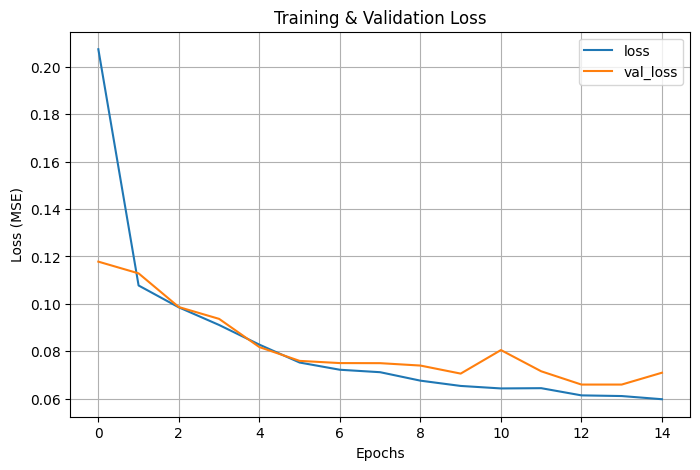

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

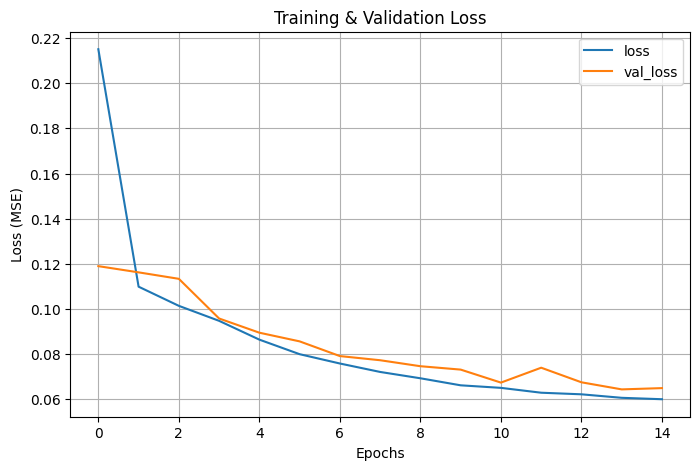

In [ ]:
Y_pred = model.predict(X_test)  # forme (n_samples, 2, 43, 57, 1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


In [ ]:
import numpy as np

# 1) erreur pixel par pixel
error = np.abs(Y_pred - Y_test)

# 2) moyenne par image
mean_error_per_output = np.mean(error, axis=(0, 2, 3, 4))
print("Erreur moyenne par image :", mean_error_per_output)

# 3) moyenne globale
global_mean_error = np.mean(mean_error_per_output)
print("Erreur moyenne globale :", global_mean_error)

Erreur moyenne par image : [0.17333089 0.19579151]
Erreur moyenne globale : 0.1845612


In [ ]:
import numpy as np

# S'assurer que Y_test a la bonne shape
if Y_test.ndim == 4:
    Y_test = Y_test[..., np.newaxis]

# Erreur absolue : (N, 2, 43, 57, 1)
abs_error = np.abs(Y_pred - Y_test)

# Moyenne de l’erreur par sample (et par image)
mean_error_per_sample = np.mean(abs_error, axis=(2,3,4))   # -> (N, 2)
# Moyenne sur les 2 images pour chaque sample
mean_error_global = mean_error_per_sample.mean(axis=1)      # -> (N,)

# Second modèle

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

inputs = Input(shape=(6, 43, 57, 1))

# --- CNN encoder amélioré ---
x = TimeDistributed(Conv2D(16, 3, padding='same', activation='relu'))(inputs)
x = TimeDistributed(Conv2D(32, 3, padding='same', activation='relu'))(x)
x = TimeDistributed(MaxPooling2D((2, 2)))(x)     # <--- AJOÛT TRÈS IMPORTANT : 43x57 -> 21x28

x = TimeDistributed(Conv2D(64, 3, padding='same', activation='relu'))(x)
x = TimeDistributed(MaxPooling2D((2, 2)))(x)     # <--- 21x28 -> 10x14

# Flatten spatial dimensions
x = TimeDistributed(Flatten())(x)   # devient ~64 * 10 * 14 = 8960 features

# --- GRU temporel renforcé ---
x = GRU(128, return_sequences=True)(x)   # <--- Upgraded
x = GRU(64, return_sequences=True)(x)    # <--- Deuxième GRU pour meilleure dynamique

# On prend les steps futurs (2)
x = Lambda(lambda t: t[:, -2:, :])(x)

# --- Reconstruction des images ---
x = TimeDistributed(Dense(10*14*32, activation='relu'))(x)
x = TimeDistributed(Reshape((10, 14, 32)))(x)

# Upsampling pour revenir à 43x57
x = TimeDistributed(Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'))(x)  # -> 20x28
x = TimeDistributed(Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu'))(x)  # -> 40x56
x = TimeDistributed(Conv2D(16, 3, padding='same', activation='relu'))(x)

# Adapter la taille finale (43x57) avec un dernier upsample ou padding
# Resize précis à (43,57)
x = TimeDistributed(Lambda(lambda t: tf.image.resize(t, (43, 57))))(x)

# Dernière conv de sortie
outputs = TimeDistributed(Conv2D(1, 3, padding='same', activation='linear'))(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 6, 43, 57, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 6, 43, 57, 16)  │           160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 6, 43, 57, 32)  │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 6, 21, 28, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 6, 21, 28, 64)  │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 6, 10, 14, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 6, 8960)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 6, 128)         │     3,490,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 6, 64)          │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 2, 4480)        │       291,200 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 2, 10, 14, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 2, 20, 28, 32)  │         9,248 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 2, 40, 56, 16)  │         4,624 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 2, 40, 56, 16)  │         2,320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 2, 43, 57, 16)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 2, 43, 57, 1)   │           145 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,858,641 (14.72 MB)

 Trainable params: 3,858,641 (14.72 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.src.callbacks import EarlyStopping
from keras.src.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),

    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),

    ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]



In [ ]:
history = model.fit(
    X_train, Y_train,
    batch_size=64,
    epochs=15,
    validation_data=(X_val, Y_val),
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.6322
Epoch 1: val_loss improved from inf to 0.11541, saving model to best_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - loss: 0.6307 - val_loss: 0.1154 - learning_rate: 0.0010
Epoch 2/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0995
Epoch 2: val_loss improved from 0.11541 to 0.08234, saving model to best_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - loss: 0.0994 - val_loss: 0.0823 - learning_rate: 0.0010
Epoch 3/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0710
Epoch 3: val_loss improved from 0.08234 to 0.07163, saving model to best_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - loss: 0.0710 - val_loss: 0.0716 - learning_rate: 0.0010
Epoch 4/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0614
Epoch 4: val_loss improved from 0.07163 to 0.06417, saving model to best_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - loss: 0.0614 - val_loss: 0.0642 - learning_

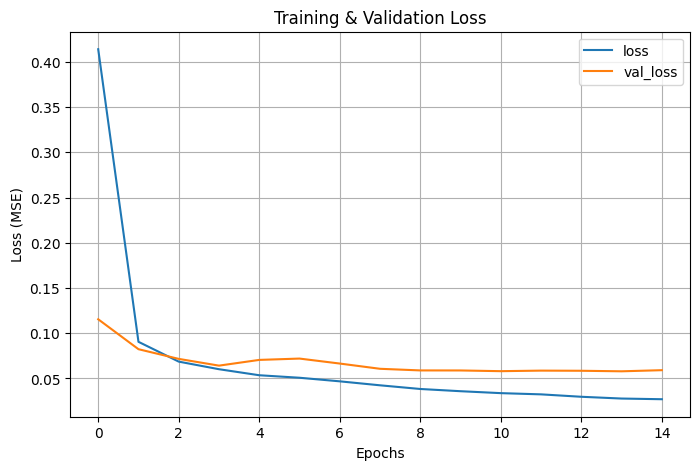

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
Y_pred = model.predict(X_test)  # forme (n_samples, 2, 43, 57, 1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


In [ ]:
import numpy as np

# 1) erreur pixel par pixel
error = np.abs(Y_pred - Y_test)

# 2) moyenne par image
mean_error_per_output = np.mean(error, axis=(0, 2, 3, 4))
print("Erreur moyenne par image :", mean_error_per_output)

# 3) moyenne globale
global_mean_error = np.mean(mean_error_per_output)
print("Erreur moyenne globale :", global_mean_error)

Erreur moyenne par image : [0.1734778  0.17312191]
Erreur moyenne globale : 0.17329985


In [ ]:
import numpy as np

# S'assurer que Y_test a la bonne shape
if Y_test.ndim == 4:
    Y_test = Y_test[..., np.newaxis]

# Erreur absolue : (N, 2, 43, 57, 1)
abs_error = np.abs(Y_pred - Y_test)

# Moyenne de l’erreur par sample (et par image)
mean_error_per_sample = np.mean(abs_error, axis=(2,3,4))   # -> (N, 2)
# Moyenne sur les 2 images pour chaque sample
mean_error_global = mean_error_per_sample.mean(axis=1)      # -> (N,)


In [ ]:
# Index du sample le plus précis
best_idx = np.argmin(mean_error_global)

print("Index du sample avec l’erreur la plus faible :", best_idx)

Index du sample avec l’erreur la plus faible : 662


In [ ]:
lon = train_ds.longitude.values
lat = train_ds.latitude.values

In [ ]:
!pip install cartopy
import cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 36.2 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_error_map(error_map, lon, lat, title="Erreur prédiction", interval=[-1.5,1.5], cmap="bwr"):
    if error_map.ndim == 3:
        error_map = error_map[:, :, 0]  # (43, 57)

    Lon2d, Lat2d = np.meshgrid(lon, lat)

    fig, ax = plt.subplots(figsize=(9,7),
                           subplot_kw={"projection": ccrs.PlateCarree()})

    ax.set_extent([-5, 9, 41, 51], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8)
    ax.add_feature(cfeature.BORDERS.with_scale("50m"), linewidth=0.6)

    gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.3)
    gl.top_labels = gl.right_labels = False

    # heatmap centrée sur 0 autour de [-1.5, 1,5]
    vmin, vmax = interval
    cf = ax.contourf(
        Lon2d, Lat2d, error_map,
        21, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree()
    )

    cbar = fig.colorbar(cf, ax=ax, orientation="vertical", shrink=0.75)
    cbar.set_label("Erreur (°C)")

    ax.set_title(title)
    plt.show()


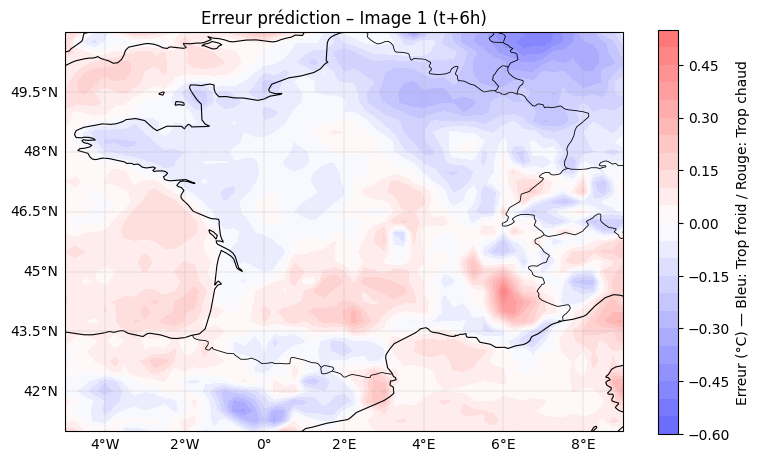

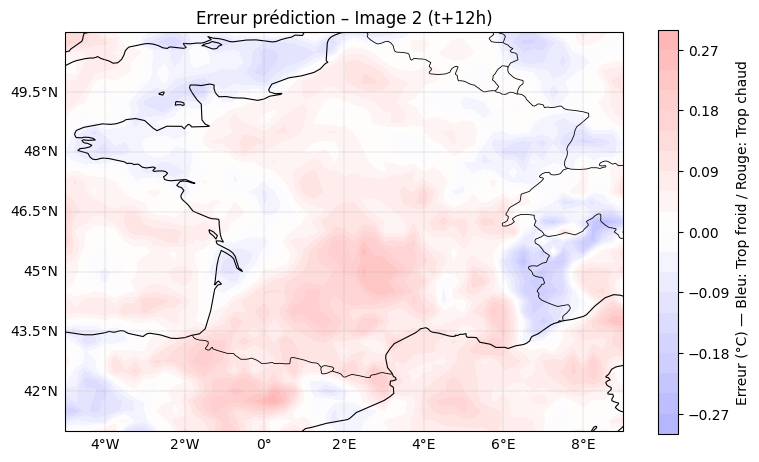

In [ ]:
# Récupération des erreurs pour le meilleur échantillon
err_img0 = Y_pred[best_idx, 0] - Y_test[best_idx, 0]
err_img1 = Y_pred[best_idx, 1] - Y_test[best_idx, 1]

# Plot
plot_error_map(err_img0, lon, lat, title="Erreur prédiction – Image 1 (t+6h)",interval=[-1,1])
plot_error_map(err_img1, lon, lat, title="Erreur prédiction – Image 2 (t+12h)",interval=[-1,1])


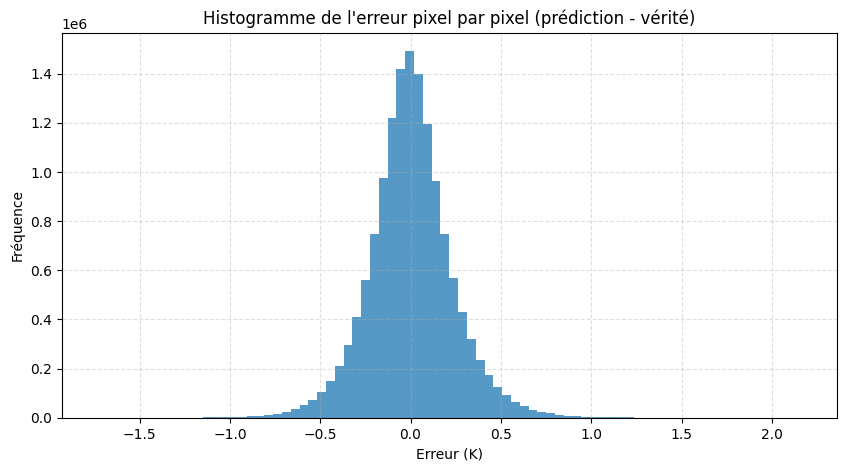

Erreur moyenne  : 0.0026435605
Erreur absolue moyenne : 0.17329971
Erreur max      : 2.1644323
Erreur min      : -1.7353048
MSE global     : 0.053881448


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------
# 1) Calcul de l'erreur pixel par pixel
# --------------------------------------------------------

# Y_pred : (N, 2, 43, 57, 1)
# Y_test : (N, 2, 43, 57, 1)
error = Y_pred - Y_test   # erreur signée (pos = trop chaud, neg = pas assez)

# On aplatit toutes les dimensions pour faire un histogramme global
error_flat = error.reshape(-1)

# --------------------------------------------------------
# 2) Trace de l'histogramme
# --------------------------------------------------------
plt.figure(figsize=(10,5))
plt.hist(error_flat, bins=80, alpha=0.75)
plt.title("Histogramme de l'erreur pixel par pixel (prédiction - vérité)")
plt.xlabel("Erreur (K)")
plt.ylabel("Fréquence")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# --------------------------------------------------------
# 3) Quelques statistiques utiles
# --------------------------------------------------------
print("Erreur moyenne  :", np.mean(error_flat))
print("Erreur absolue moyenne :", np.mean(np.abs(error_flat)))
print("Erreur max      :", np.max(error_flat))
print("Erreur min      :", np.min(error_flat))
print("MSE global     :", np.mean(error_flat**2))


# Troisième modèle

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import (
    Input,
    BatchNormalization,
    TimeDistributed,
    MaxPooling2D,
    Conv2DTranspose,
    Lambda,
    Conv2D,
    RepeatVector,  # On peut même le supprimer de l'import
    ConvLSTM2D
)
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.optimizers import Adam

def gradient_penalty(y_true, y_pred):
    dy_pred = y_pred[:, :, 1:, :, :] - y_pred[:, :, :-1, :, :]
    dx_pred = y_pred[:, :, :, 1:, :] - y_pred[:, :, :, :-1, :]

    return 0.05 * (tf.reduce_mean(tf.abs(dx_pred)) + tf.reduce_mean(tf.abs(dy_pred)))

def final_loss(y_true, y_pred):
    huber = tf.keras.losses.Huber(delta=1.0)(y_true, y_pred)
    gp = gradient_penalty(y_true, y_pred)
    return huber + gp

def conv_block(x, filters):
    x = TimeDistributed(Conv2D(filters, (3,3), padding="same", activation="relu"))(x)
    x = TimeDistributed(Conv2D(filters, (3,3), padding="same", activation="relu"))(x)
    return x

def build_convlstm_model(input_shape=(6, 43, 57, 1), output_steps=2):
    """
    Construit un modèle Encoder-Decoder ConvLSTM.
    """
    inputs = Input(shape=input_shape)

    # --- ENCODER ---
    x = ConvLSTM2D(
        filters=32,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        activation='relu'
    )(inputs)
    x = BatchNormalization()(x)

    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    skip_32 = x

    x = ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        activation='relu'
    )(x)
    x = BatchNormalization()(x)

    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    skip_64 = x

    x = ConvLSTM2D(
    filters=96,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=True,
    activation='relu'
    )(x)
    x = BatchNormalization()(x)

    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = ConvLSTM2D(
        filters=128,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=False, # <-- Donne (Batch, 10, 14, 128)
        activation='relu'
    )(x)

    # --- PONT (Bridge) ---

    # LIGNE SUPPRIMÉE (incorrecte) :
    # x = RepeatVector(output_steps)(x)

    # CORRECTION : Utiliser Lambda pour expand_dims et tile
    # 1. tf.expand_dims(x, axis=1) -> (Batch, 1, 10, 14, 128)
    # 2. tf.tile(...) -> (Batch, 2, 10, 14, 128)
    x = Lambda(
        lambda t: tf.tile(tf.expand_dims(t, axis=1), [1, output_steps, 1, 1, 1])
    )(x)

    # --- DECODER ---
    # L'entrée est maintenant (Batch, 2, 10, 14, 128), ce qui est correct !
    x = ConvLSTM2D(
        filters=128,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True, # <-- Très important
        activation='relu',
        dropout=0.2,
        recurrent_dropout=0.2
    )(x)
    x = BatchNormalization()(x)

    x = conv_block(x, 128)

    # --- UPSAMPLE 1 : (5,7) → (10,14)
    x = TimeDistributed(Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'))(x)
    x = BatchNormalization()(x)

    # --- SKIP CONNECTION ---
    skip_64 = Lambda(lambda t: t[:, -output_steps:, :, :, :])(skip_64)
    x = tf.keras.layers.Concatenate(axis=-1)([x, skip_64])

    # Optionnel mais conseillé : petit conv_block
    x = conv_block(x, 64)

    # --- UPSAMPLE 2 : (10,14) → (20,28)
    x = TimeDistributed(Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'))(x)
    x = BatchNormalization()(x)

    # --- UPSAMPLE FINAL → (43,57)
    x = TimeDistributed(Lambda(lambda t: tf.image.resize(t, (43, 57))))(x)

    skip_32 = Lambda(lambda t: t[:, -output_steps:])(skip_32)
    skip_32 = TimeDistributed(Lambda(lambda t: tf.image.resize(t, (43, 57))))(skip_32)
    x = tf.keras.layers.Concatenate(axis=-1)([x, skip_32])
    x = conv_block(x, 32)

    x = TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'))(x)
    outputs = TimeDistributed(Conv2D(1, (1, 1), padding='same', activation='linear'))(x)

    model = Model(inputs, outputs)
    return model

# --- Configuration et Entraînement ---
model = build_convlstm_model() # Utiliser la nouvelle fonction

lr_schedule = CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=5,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-6
)

model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=final_loss,
    metrics=['mae']
)
model.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 6, 43, 57, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 6, 43, 57, │     38,144 │ input_layer[0][0] │
│ (ConvLSTM2D)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 6, 43, 57, │        128 │ conv_lstm2d[0][0] │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 6, 21, 28, │          0 │ batch_normalizat… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 6, 21, 28, │    221,440 │ time_distributed… │
│ (ConvLSTM2D)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 21, 28, │        256 │ conv_lstm2d_1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 6, 10, 14, │          0 │ batch_normalizat… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_2       │ (None, 6, 10, 14, │    553,344 │ time_distributed… │
│ (ConvLSTM2D)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 10, 14, │        384 │ conv_lstm2d_2[0]… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 6, 5, 7,   │          0 │ batch_normalizat… │
│ (TimeDistributed)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_3       │ (None, 5, 7, 128) │  1,032,704 │ time_distributed… │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 2, 5, 7,   │          0 │ conv_lstm2d_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_4       │ (None, 2, 5, 7,   │  1,180,160 │ lambda[0][0]      │
│ (ConvLSTM2D)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 5, 7,   │        512 │ conv_lstm2d_4[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 2, 5, 7,   │    147,584 │ batch_normalizat… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 2, 5, 7,   │    147,584 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 2, 10, 14, │     73,792 │ time_distributed

 Total params: 3,557,953 (13.57 MB)

 Trainable params: 3,557,121 (13.57 MB)

 Non-trainable params: 832 (3.25 KB)

In [ ]:
import tensorflow as tf
import numpy as np
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

# --- 1. CRÉATION DES PIPELINES DE DONNÉES (tf.data.Dataset) ---
BATCH_SIZE = 32 # Tirez parti de la puissance du GPU, ajustez si manque de VRAM

# Créer les datasets à partir de vos tableaux NumPy
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

# Préparer le pipeline d'entraînement : Mélange, Batch, Préfetche
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)) \
                             .batch(BATCH_SIZE) \
                             .prefetch(tf.data.AUTOTUNE)

# Préparer le pipeline de validation : Batch, Préfetche
val_dataset = val_dataset.batch(BATCH_SIZE) \
                         .prefetch(tf.data.AUTOTUNE)

print("Pipelines tf.data.Dataset créés avec succès.")


# --- 2. DÉFINITION DES CALLBACKS ---
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,          # Attend 15 époques de stagnation
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_convlstm_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# --- 3. ENTRAÎNEMENT DU MODÈLE ---
print("\nLancement de l'entraînement...")

history = model.fit(
    train_dataset,
    epochs=15, # Sera arrêté par EarlyStopping
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

print("\nEntraînement terminé. Le modèle optimal est sauvegardé.")

Pipelines tf.data.Dataset créés avec succès.

Lancement de l'entraînement...
Epoch 1/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.1241 - mae: 0.3632
Epoch 1: val_loss improved from inf to 0.33072, saving model to best_convlstm_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 143s 350ms/step - loss: 0.1240 - mae: 0.3630 - val_loss: 0.3307 - val_mae: 0.6762
Epoch 2/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0534 - mae: 0.2319
Epoch 2: val_loss improved from 0.33072 to 0.11063, saving model to best_convlstm_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 63s 228ms/step - loss: 0.0534 - mae: 0.2319 - val_loss: 0.1106 - val_mae: 0.3588
Epoch 3/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0424 - mae: 0.2011
Epoch 3: val_loss improved from 0.11063 to 0.04564, saving model to best_convlstm_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 62s 225ms/step - loss: 0.0424 - mae: 0.2011 - val_loss: 0.0456 - val_mae: 0.2096
Epoch 4/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0

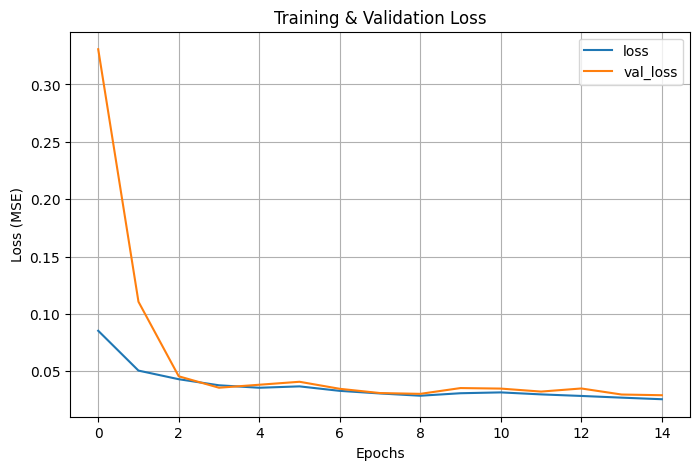

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
Y_pred = model.predict(X_test)  # forme (n_samples, 2, 43, 57, 1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step


In [ ]:
# Préparation à la prédiction récursive
X_part = X_test[:, 1:6, :, :, :]     # 5 derniers de X_test → shape (2917, 5, 43, 57, 1)
Y_part = Y_pred[:, 0:1, :, :, :]     # 1er de Y_pred → shape (2917, 1, 43, 57, 1)

new_array = np.concatenate([X_part, Y_part], axis=1)
print(new_array.shape)  #(2917, 6, 43, 57, 1)

(2917, 6, 43, 57, 1)


In [ ]:
Y_pred2 = model.predict(new_array)

92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step


In [ ]:
# Préduction récursive finale
Y_pred_rec = np.concatenate([Y_part, Y_pred2[:, 0:1, :, :, :]], axis=1)
print(Y_pred_rec.shape)

(2917, 2, 43, 57, 1)


In [ ]:
import numpy as np

# S'assurer que Y_test a la bonne shape
if Y_test.ndim == 4:
    Y_test = Y_test[..., np.newaxis]

# 1) erreur pixel par pixel
error = np.abs(Y_pred - Y_test)

# 2) moyenne par image
mean_error_per_output = np.mean(error, axis=(0, 2, 3, 4))
print("Erreur moyenne par image :", mean_error_per_output)

# 3) moyenne globale
global_mean_error = np.mean(mean_error_per_output)
print("Erreur moyenne globale :", global_mean_error)


# Erreur prédiction récursive
# 1) erreur pixel par pixel
error_rec = np.abs(Y_pred_rec - Y_test)

# 2) moyenne par image
mean_error_rec_per_output = np.mean(error_rec, axis=(0, 2, 3, 4))
print("Erreur moyenne par image en récursif :", mean_error_rec_per_output)

# 3) moyenne globale
global_mean_error_rec = np.mean(mean_error_rec_per_output)
print("Erreur moyenne globale en récursif :", global_mean_error_rec)

Erreur moyenne par image : [0.13586941 0.16654265]
Erreur moyenne globale : 0.15120603
Erreur moyenne par image en récursif : [0.13586941 0.17214595]
Erreur moyenne globale en récursif : 0.15400767


In [ ]:
import numpy as np

# S'assurer que Y_test a la bonne shape
if Y_test.ndim == 4:
    Y_test = Y_test[..., np.newaxis]

# Erreur absolue : (N, 2, 43, 57, 1)
abs_error = np.abs(Y_pred - Y_test)

# Moyenne de l’erreur par sample (et par image)
mean_error_per_sample = np.mean(abs_error, axis=(2,3,4))   # -> (N, 2)
# Moyenne sur les 2 images pour chaque sample
mean_error_global = mean_error_per_sample.mean(axis=1)      # -> (N,)


In [ ]:
# Index du sample le plus précis
best_idx = np.argmin(mean_error_global)

print("Index du sample avec l’erreur la plus faible :", best_idx)

Index du sample avec l’erreur la plus faible : 662


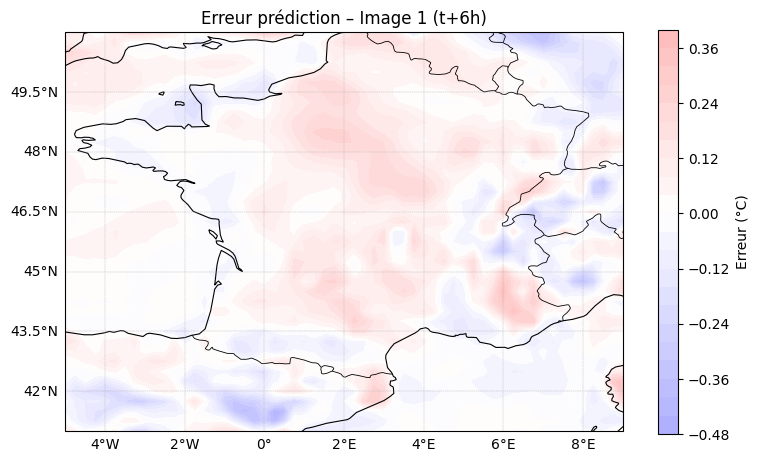

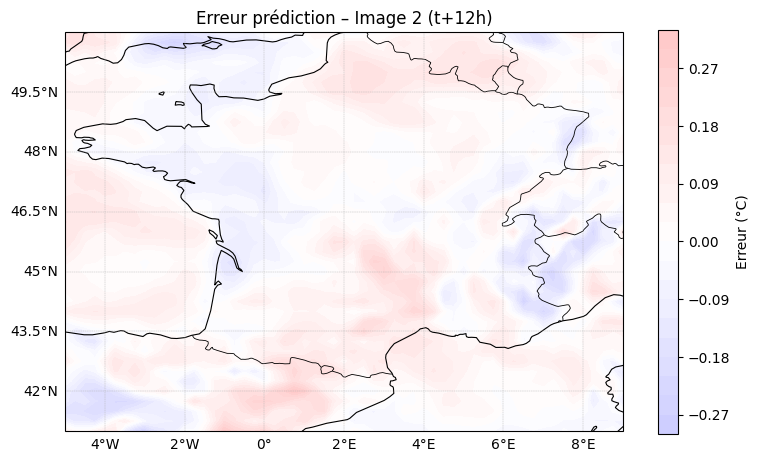

In [ ]:
# Récupération des erreurs pour le meilleur échantillon
err_img0 = Y_pred[best_idx, 0] - Y_test[best_idx, 0]
err_img1 = Y_pred[best_idx, 1] - Y_test[best_idx, 1]

# Plot
plot_error_map(err_img0, lon, lat, title="Erreur prédiction – Image 1 (t+6h)")
plot_error_map(err_img1, lon, lat, title="Erreur prédiction – Image 2 (t+12h)")


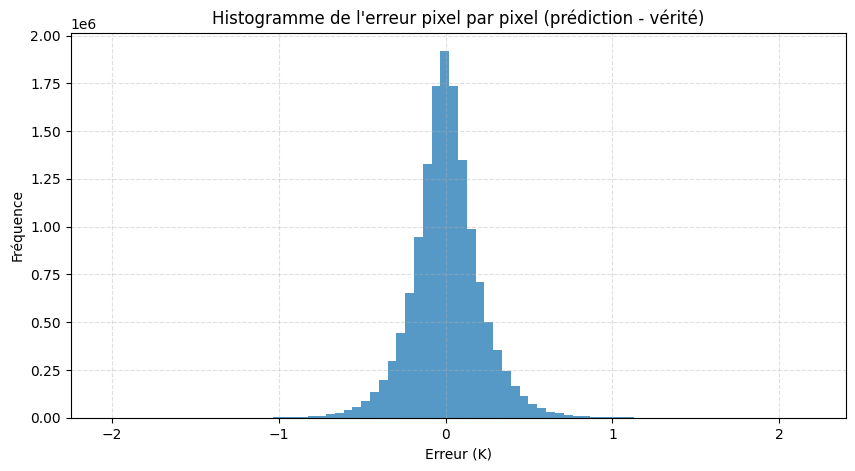

Erreur moyenne  : 0.004553807
Erreur absolue moyenne : 0.15120594
Erreur max      : 2.1859202
Erreur min      : -2.0373812
MSE global     : 0.042310722


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------
# 1) Calcul de l'erreur pixel par pixel
# --------------------------------------------------------

# Y_pred : (N, 2, 43, 57, 1)
# Y_test : (N, 2, 43, 57, 1)
error = Y_pred - Y_test   # erreur signée (pos = trop chaud, neg = pas assez)

# On aplatit toutes les dimensions pour faire un histogramme global
error_flat = error.reshape(-1)

# --------------------------------------------------------
# 2) Trace de l'histogramme
# --------------------------------------------------------
plt.figure(figsize=(10,5))
plt.hist(error_flat, bins=80, alpha=0.75)
plt.title("Histogramme de l'erreur pixel par pixel (prédiction - vérité)")
plt.xlabel("Erreur (K)")
plt.ylabel("Fréquence")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# --------------------------------------------------------
# 3) Quelques statistiques utiles
# --------------------------------------------------------
print("Erreur moyenne  :", np.mean(error_flat))
print("Erreur absolue moyenne :", np.mean(np.abs(error_flat)))
print("Erreur max      :", np.max(error_flat))
print("Erreur min      :", np.min(error_flat))
print("MSE global     :", np.mean(error_flat**2))

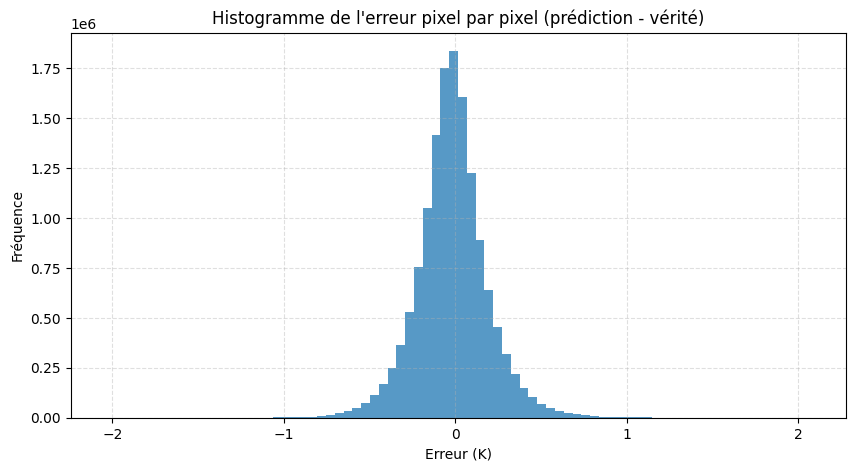

Erreur moyenne  : -0.018137934
Erreur absolue moyenne : 0.15356958
Erreur max      : 2.0693805
Erreur min      : -2.037736
MSE global     : 0.043377608

(2917, 2, 43, 57, 1)
(2, 43, 57)


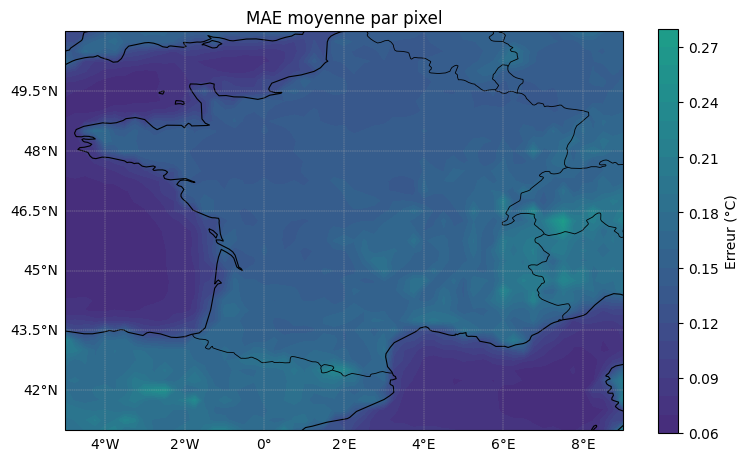

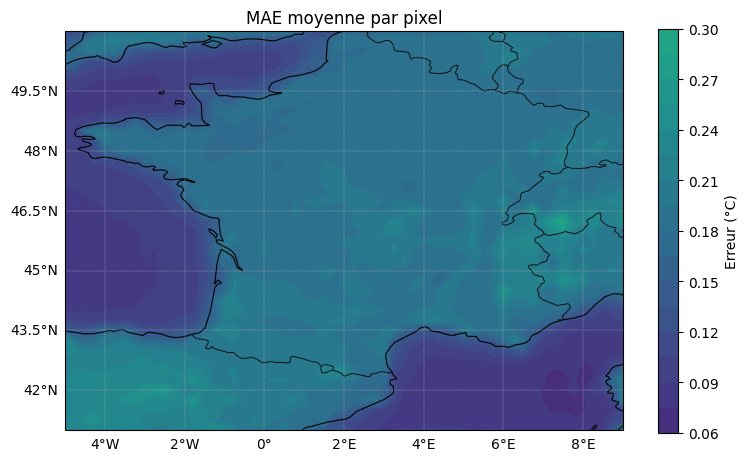

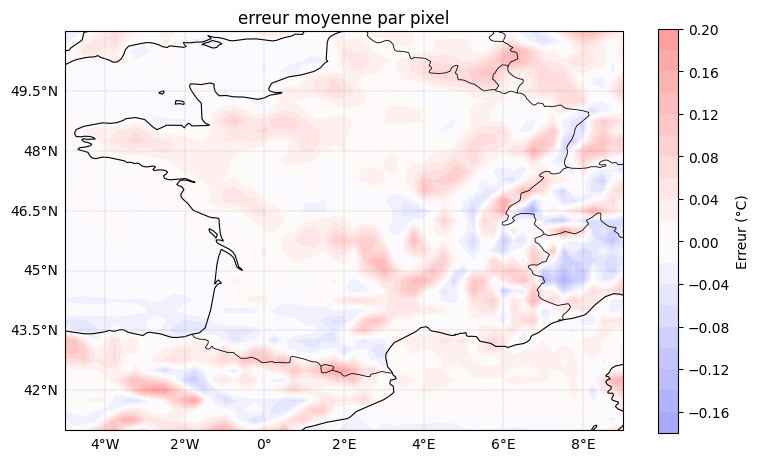

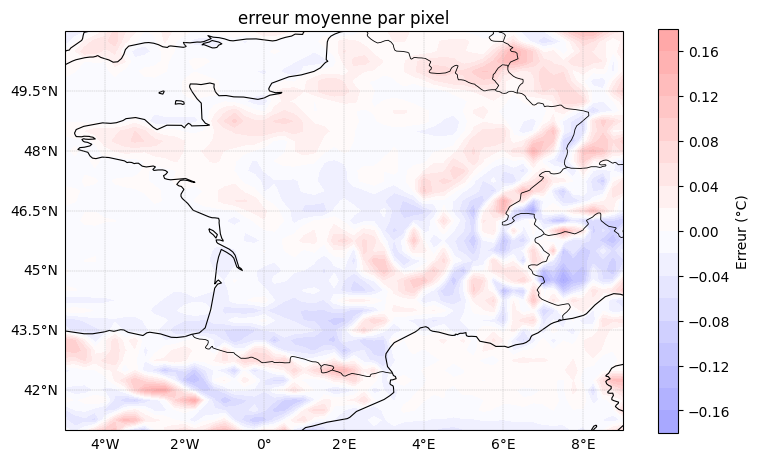

In [ ]:
error = np.abs(Y_pred - Y_test)
print(error.shape)
mean_mae_err = np.mean(error, axis=(0, 4))
print(err.shape)
plot_error_map(mean_mae_err[0], lon, lat, title="MAE moyenne par pixel",interval=[0,0.5], cmap="viridis")
plot_error_map(mean_mae_err[1], lon, lat, title="MAE moyenne par pixel",interval=[0,0.5], cmap="viridis")

mean_err = np.mean(Y_pred - Y_test, axis=(0, 4))
plot_error_map(mean_err[0], lon, lat, title="erreur moyenne par pixel",interval=[-0.5,0.5])
plot_error_map(mean_err[1], lon, lat, title="erreur moyenne par pixel",interval=[-0.5,0.5])

# troisième modèle N=6 P=10

In [ ]:
N = 6  # 5 temps en entrée
P = 10  # 10 temps à prédire

X_train, Y_train = build_XY_fast(train_ds, N, P)
X_val, Y_val = build_XY_fast(val_ds,N,P)
X_test, Y_test = build_XY_fast(test_ds,N,P)


mean = X_train.mean()
std  = X_train.std()

X_train = (X_train - mean) / std
Y_train = (Y_train - mean) / std   # important !

X_val = (X_val - mean) / std
Y_val = (Y_val - mean) / std

X_test = (X_test - mean) / std
Y_test = (Y_test - mean) / std

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(8753, 6, 43, 57)
(8753, 10, 43, 57)
(2909, 6, 43, 57)


In [ ]:
X_train = X_train[..., np.newaxis]  # (7298, 5, 43, 57, 1)
Y_train = Y_train[..., np.newaxis]  # (7298, 2, 43, 57, 1)
X_val = X_val[..., np.newaxis]  # (1454, 5, 43, 57, 1)
Y_val = Y_val[..., np.newaxis]  # (1454, 2, 43, 57, 1)
X_test = X_test[..., np.newaxis]  # (1454, 5, 43, 57, 1)
Y_test = Y_test[..., np.newaxis]  # (1454, 2, 43, 57, 1)

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import (
    Input,
    BatchNormalization,
    TimeDistributed,
    MaxPooling2D,
    Conv2DTranspose,
    Lambda,
    Conv2D,
    RepeatVector,  # On peut même le supprimer de l'import
    ConvLSTM2D
)
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.optimizers import Adam

def gradient_penalty(y_true, y_pred):
    dy_pred = y_pred[:, :, 1:, :, :] - y_pred[:, :, :-1, :, :]
    dx_pred = y_pred[:, :, :, 1:, :] - y_pred[:, :, :, :-1, :]

    return 0.05 * (tf.reduce_mean(tf.abs(dx_pred)) + tf.reduce_mean(tf.abs(dy_pred)))

def final_loss(y_true, y_pred):
    huber = tf.keras.losses.Huber(delta=1.0)(y_true, y_pred)
    gp = gradient_penalty(y_true, y_pred)
    return huber + gp

def conv_block(x, filters):
    x = TimeDistributed(Conv2D(filters, (3,3), padding="same", activation="relu"))(x)
    x = TimeDistributed(Conv2D(filters, (3,3), padding="same", activation="relu"))(x)
    return x

def build_convlstm_model(input_shape=(6, 43, 57, 1), output_steps=10):
    """
    Construit un modèle Encoder-Decoder ConvLSTM.
    """
    inputs = Input(shape=input_shape)

    # --- ENCODER ---
    x = ConvLSTM2D(
        filters=32,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        activation='relu'
    )(inputs)
    x = BatchNormalization()(x)

    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    skip_32 = x

    x = ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        activation='relu'
    )(x)
    x = BatchNormalization()(x)

    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    skip_64 = x

    x = ConvLSTM2D(
    filters=96,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=True,
    activation='relu'
    )(x)
    x = BatchNormalization()(x)

    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = ConvLSTM2D(
        filters=128,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=False, # <-- Donne (Batch, 10, 14, 128)
        activation='relu'
    )(x)

    # --- PONT (Bridge) ---

    # LIGNE SUPPRIMÉE (incorrecte) :
    # x = RepeatVector(output_steps)(x)

    # CORRECTION : Utiliser Lambda pour expand_dims et tile
    # 1. tf.expand_dims(x, axis=1) -> (Batch, 1, 10, 14, 128)
    # 2. tf.tile(...) -> (Batch, 2, 10, 14, 128)
    x = Lambda(
        lambda t: tf.tile(tf.expand_dims(t, axis=1), [1, output_steps, 1, 1, 1])
    )(x)

    # --- DECODER ---
    # L'entrée est maintenant (Batch, 2, 10, 14, 128), ce qui est correct !
    x = ConvLSTM2D(
        filters=128,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True, # <-- Très important
        activation='relu',
        dropout=0.2,
        recurrent_dropout=0.2
    )(x)
    x = BatchNormalization()(x)

    x = conv_block(x, 128)

    # --- UPSAMPLE 1 : (5,7) → (10,14)
    x = TimeDistributed(Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'))(x)
    x = BatchNormalization()(x)

    # --- SKIP CONNECTION ---
    skip_64 = Lambda(lambda t: tf.tile(t[:, -1:, :, :, :], [1, output_steps, 1, 1, 1]))(skip_64)
    x = tf.keras.layers.Concatenate(axis=-1)([x, skip_64])

    # Optionnel mais conseillé : petit conv_block
    x = conv_block(x, 64)

    # --- UPSAMPLE 2 : (10,14) → (20,28)
    x = TimeDistributed(Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'))(x)
    x = BatchNormalization()(x)

    # --- UPSAMPLE FINAL → (43,57)
    x = TimeDistributed(Lambda(lambda t: tf.image.resize(t, (43, 57))))(x)

    skip_32 = Lambda(lambda t: tf.tile(t[:, -1:, :, :, :], [1, output_steps, 1, 1, 1]))(skip_32)
    skip_32 = TimeDistributed(Lambda(lambda t: tf.image.resize(t, (43, 57))))(skip_32)
    x = tf.keras.layers.Concatenate(axis=-1)([x, skip_32])
    x = conv_block(x, 32)

    x = TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'))(x)
    outputs = TimeDistributed(Conv2D(1, (1, 1), padding='same', activation='linear'))(x)

    model = Model(inputs, outputs)
    return model

# --- Configuration et Entraînement ---
model = build_convlstm_model() # Utiliser la nouvelle fonction

lr_schedule = CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=5,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-6
)

model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=final_loss,
    metrics=['mae']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 6, 43, 57, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 6, 43, 57, │     38,144 │ input_layer[0][0] │
│ (ConvLSTM2D)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 6, 43, 57, │        128 │ conv_lstm2d[0][0] │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 6, 21, 28, │          0 │ batch_normalizat… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 6, 21, 28, │    221,440 │ time_distributed… │
│ (ConvLSTM2D)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 21, 28, │        256 │ conv_lstm2d_1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 6, 10, 14, │          0 │ batch_normalizat… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_2       │ (None, 6, 10, 14, │    553,344 │ time_distributed… │
│ (ConvLSTM2D)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 10, 14, │        384 │ conv_lstm2d_2[0]… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 6, 5, 7,   │          0 │ batch_normalizat… │
│ (TimeDistributed)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_3       │ (None, 5, 7, 128) │  1,032,704 │ time_distributed… │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 10, 5, 7,  │          0 │ conv_lstm2d_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_4       │ (None, 10, 5, 7,  │  1,180,160 │ lambda[0][0]      │
│ (ConvLSTM2D)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 5, 7,  │        512 │ conv_lstm2d_4[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 10, 5, 7,  │    147,584 │ batch_normalizat… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 10, 5, 7,  │    147,584 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 10, 10,    │     73,792 │ time_distributed

 Total params: 3,557,953 (13.57 MB)

 Trainable params: 3,557,121 (13.57 MB)

 Non-trainable params: 832 (3.25 KB)

In [ ]:
import tensorflow as tf
import numpy as np
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

# --- 1. CRÉATION DES PIPELINES DE DONNÉES (tf.data.Dataset) ---
BATCH_SIZE = 32 # Tirez parti de la puissance du GPU, ajustez si manque de VRAM

# Créer les datasets à partir de vos tableaux NumPy
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

# Préparer le pipeline d'entraînement : Mélange, Batch, Préfetche
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)) \
                             .batch(BATCH_SIZE) \
                             .prefetch(tf.data.AUTOTUNE)

# Préparer le pipeline de validation : Batch, Préfetche
val_dataset = val_dataset.batch(BATCH_SIZE) \
                         .prefetch(tf.data.AUTOTUNE)

print("Pipelines tf.data.Dataset créés avec succès.")


# --- 2. DÉFINITION DES CALLBACKS ---
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,           # Divise le taux par 2
        patience=5,           # Attend 5 époques de stagnation
        min_lr=1e-6,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,          # Attend 15 époques de stagnation
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_convlstm_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# --- 3. ENTRAÎNEMENT DU MODÈLE ---
print("\nLancement de l'entraînement...")

history = model.fit(
    train_dataset,
    epochs=7, # Sera arrêté par EarlyStopping
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

print("\nEntraînement terminé. Le modèle optimal est sauvegardé.")

Pipelines tf.data.Dataset créés avec succès.

Lancement de l'entraînement...
Epoch 1/7
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - loss: 0.1714 - mae: 0.4406
Epoch 1: val_loss improved from inf to 0.30986, saving model to best_convlstm_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 242s 618ms/step - loss: 0.1713 - mae: 0.4405 - val_loss: 0.3099 - val_mae: 0.6454 - learning_rate: 9.0615e-05
Epoch 2/7
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 0.1358 - mae: 0.3878
Epoch 2: val_loss improved from 0.30986 to 0.15265, saving model to best_convlstm_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 139s 365ms/step - loss: 0.1358 - mae: 0.3878 - val_loss: 0.1526 - val_mae: 0.4190 - learning_rate: 9.1174e-05
Epoch 3/7
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - loss: 0.1301 - mae: 0.3779
Epoch 3: val_loss improved from 0.15265 to 0.14183, saving model to best_convlstm_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 103s 370ms/step - loss: 0.1301 - mae: 0.3779 - val_loss: 0.1418 - val_mae: 0.4012 - learning

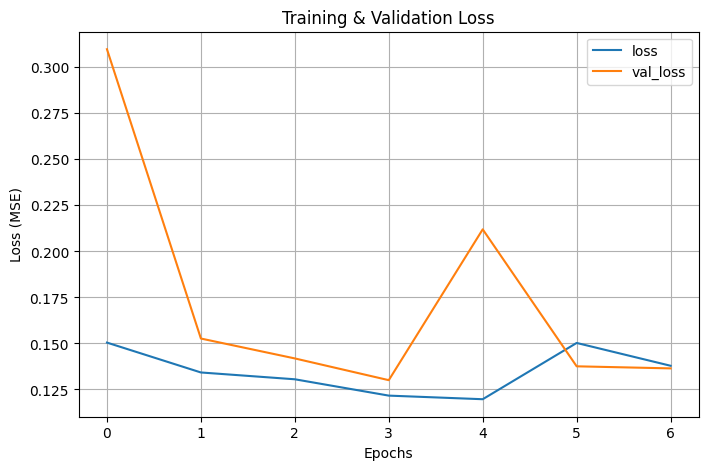

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
Y_pred = model.predict(X_test)  # forme (n_samples, 2, 43, 57, 1)

91/91 ━━━━━━━━━━━━━━━━━━━━ 23s 174ms/step


In [ ]:
X_part = X_test
Y_pred_rec = Y_pred[:, 0:1, :, :, :]

for _ in range(P-1):
  # Préparation à la prédiction récursive
  X_part = X_part[:, 1:6, :, :, :]     # 5 derniers de X_test → shape (2917, 5, 43, 57, 1)
  Y_part = Y_pred_rec[:, -1:, :, :, :]     # Fix: Get the last frame, not an empty slice

  X_part = np.concatenate([X_part, Y_part], axis=1)

  Y_pred2 = model.predict(X_part)

  # Préduction récursive finale
  Y_pred_rec = np.concatenate([Y_pred_rec, Y_pred2[:, 0:1, :, :, :]], axis=1)
  print(Y_pred_rec.shape)

91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step
(2909, 2, 43, 57, 1)
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step
(2909, 3, 43, 57, 1)
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step
(2909, 4, 43, 57, 1)
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step
(2909, 5, 43, 57, 1)
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step
(2909, 6, 43, 57, 1)
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step
(2909, 7, 43, 57, 1)
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step
(2909, 8, 43, 57, 1)
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step
(2909, 9, 43, 57, 1)
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step
(2909, 10, 43, 57, 1)


In [ ]:
import numpy as np

# S'assurer que Y_test a la bonne shape
if Y_test.ndim == 4:
    Y_test = Y_test[..., np.newaxis]

# 1) erreur pixel par pixel
error = np.abs(Y_pred - Y_test)

# 2) moyenne par image
mean_error_per_output = np.mean(error, axis=(0, 2, 3, 4))
print("Erreur moyenne par image :", mean_error_per_output)

# 3) moyenne globale
global_mean_error = np.mean(mean_error_per_output)
print("Erreur moyenne globale :", global_mean_error)


# Erreur prédiction récursive
# 1) erreur pixel par pixel
error_rec = np.abs(Y_pred_rec - Y_test)

# 2) moyenne par image
mean_error_rec_per_output = np.mean(error_rec, axis=(0, 2, 3, 4))
print("Erreur moyenne par image en récursif :", mean_error_rec_per_output)

# 3) moyenne globale
global_mean_error_rec = np.mean(mean_error_rec_per_output)
print("Erreur moyenne globale en récursif :", global_mean_error_rec)

Erreur moyenne par image : [0.2777278  0.3427728  0.34344655 0.35666737 0.37501234 0.39861405
 0.38990057 0.39783844 0.40738317 0.4352307 ]
Erreur moyenne globale : 0.37245938
Erreur moyenne par image en récursif : [0.2777278  0.3088237  0.31701216 0.34187564 0.42295963 0.46986258
 0.49235564 0.5255863  0.58452654 0.62550324]
Erreur moyenne globale en récursif : 0.43662333


In [ ]:
import numpy as np
# S'assurer que Y_test a la bonne shape
if Y_test.ndim == 4:
    Y_test = Y_test[..., np.newaxis]

# 1) erreur pixel par pixel
error = np.abs(Y_pred - Y_test)

# 2) moyenne par image
mean_error_per_output = np.mean(error, axis=(0, 2, 3, 4))
print("Erreur moyenne par image :", mean_error_per_output)

# 3) moyenne globale
global_mean_error = np.mean(mean_error_per_output)
print("Erreur moyenne globale :", global_mean_error)

Erreur moyenne par image : [0.2777278  0.3427728  0.34344655 0.35666737 0.37501234 0.39861405
 0.38990057 0.39783844 0.40738317 0.4352307 ]
Erreur moyenne globale : 0.37245938


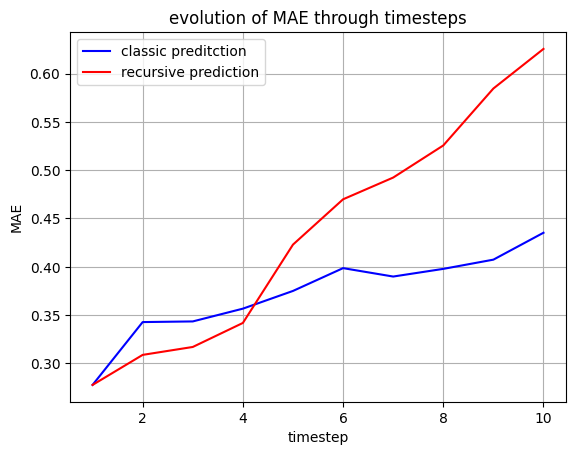

In [ ]:
plt.plot(np.linspace(1,10,10),mean_error_per_output,color="blue", label="classic preditction")
plt.plot(np.linspace(1,10,10),mean_error_rec_per_output,color="red", label="recursive prediction")
plt.xlabel("timestep")
plt.ylabel("MAE")
plt.title("evolution of MAE through timesteps")
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np

# S'assurer que Y_test a la bonne shape
if Y_test.ndim == 4:
    Y_test = Y_test[..., np.newaxis]

# Erreur absolue : (N, 2, 43, 57, 1)
abs_error = np.abs(Y_pred - Y_test)

# Moyenne de l’erreur par sample (et par image)
mean_error_per_sample = np.mean(abs_error, axis=(2,3,4))   # -> (N, 2)
# Moyenne sur les 2 images pour chaque sample
mean_error_global = mean_error_per_sample.mean(axis=1)      # -> (N,)

In [ ]:
# Index du sample le plus précis
best_idx = np.argmin(mean_error_global)

print("Index du sample avec l’erreur la plus faible :", best_idx)
lon = train_ds.longitude.values
lat = train_ds.latitude.values

Index du sample avec l’erreur la plus faible : 1465


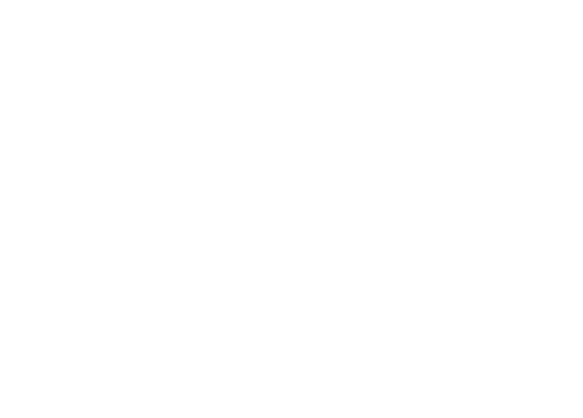

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


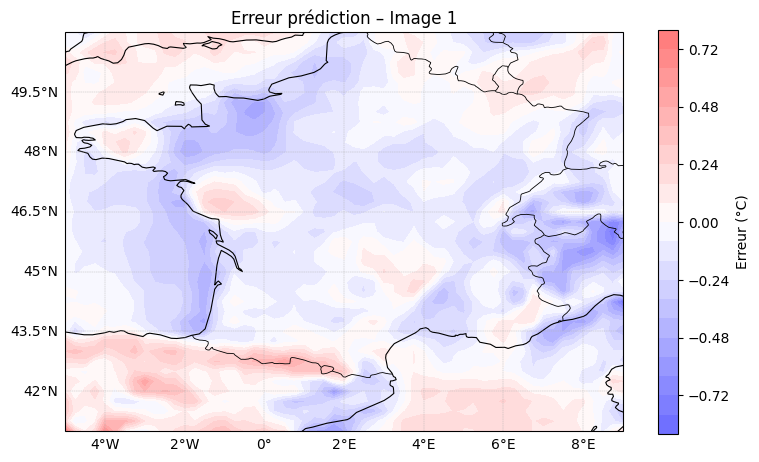

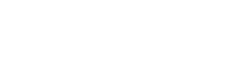

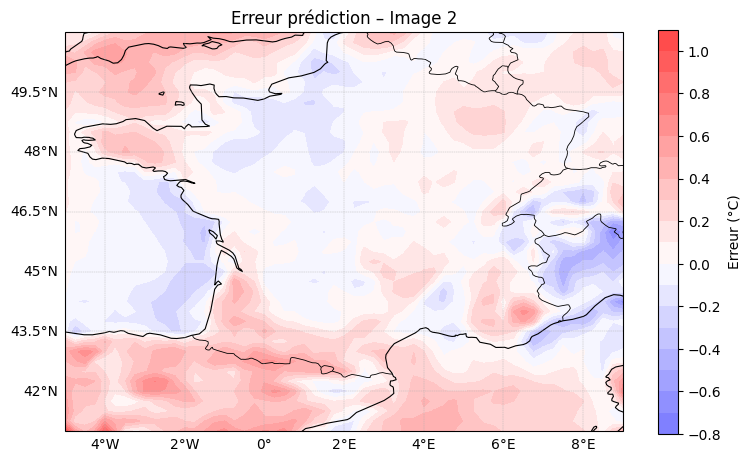

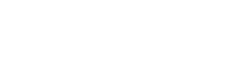

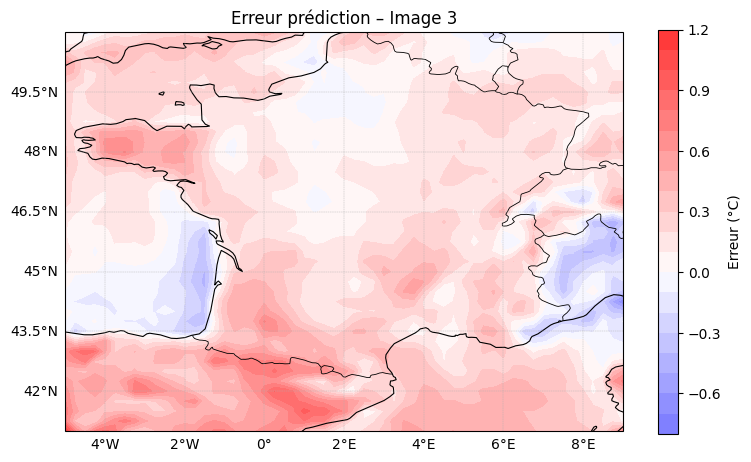

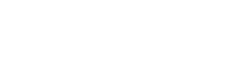

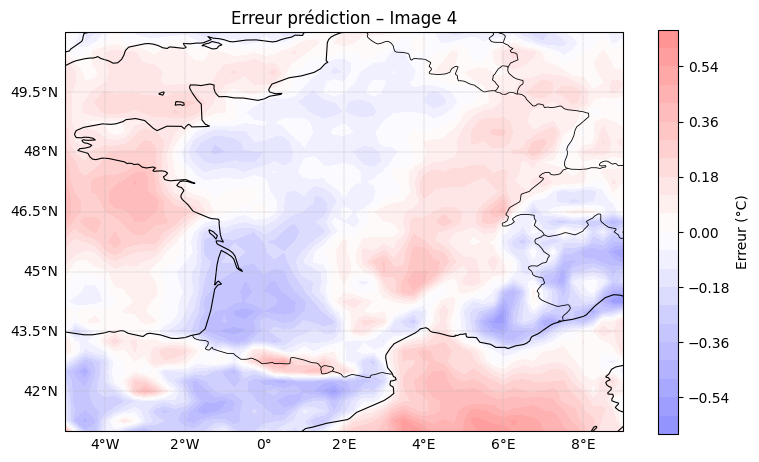

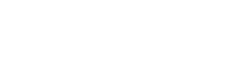

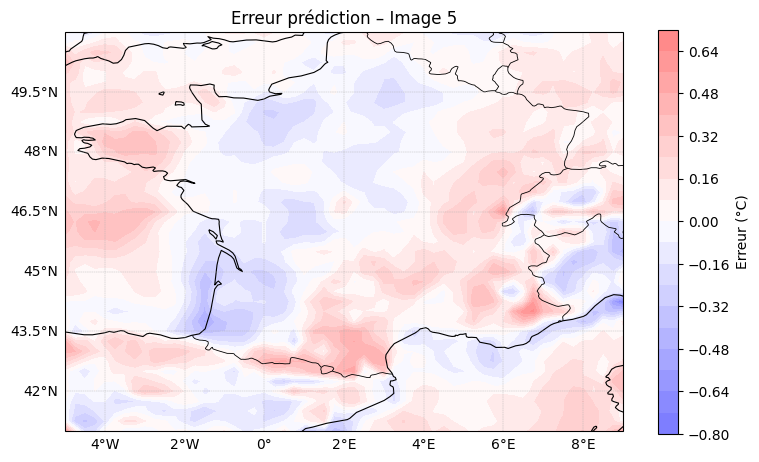

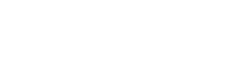

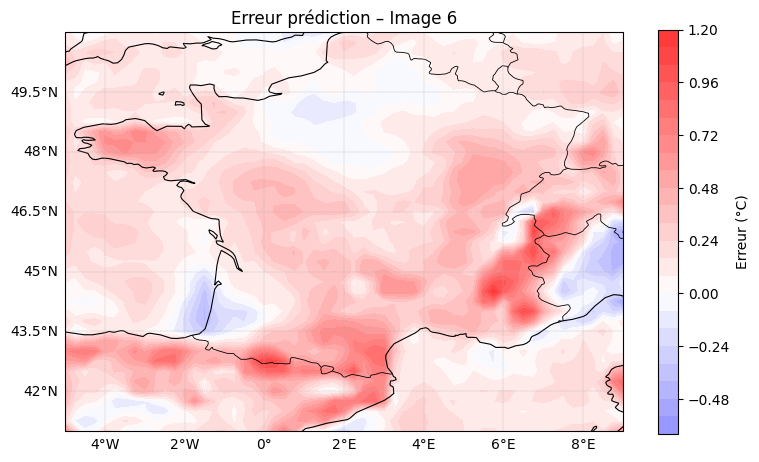

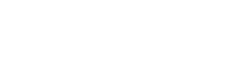

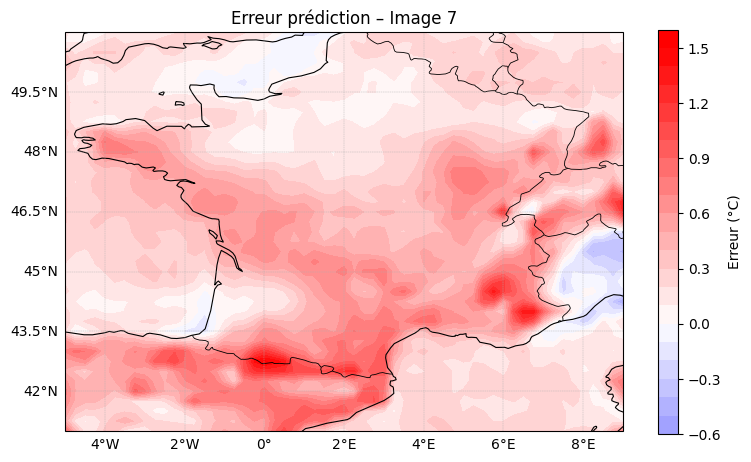

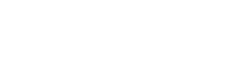

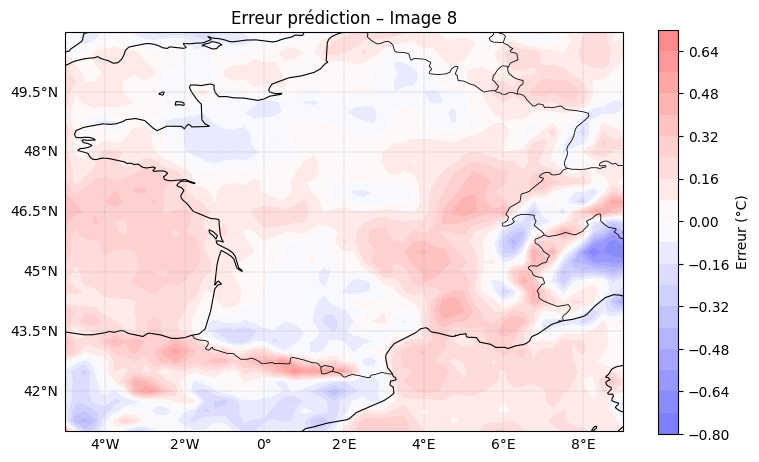

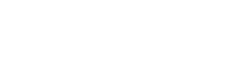

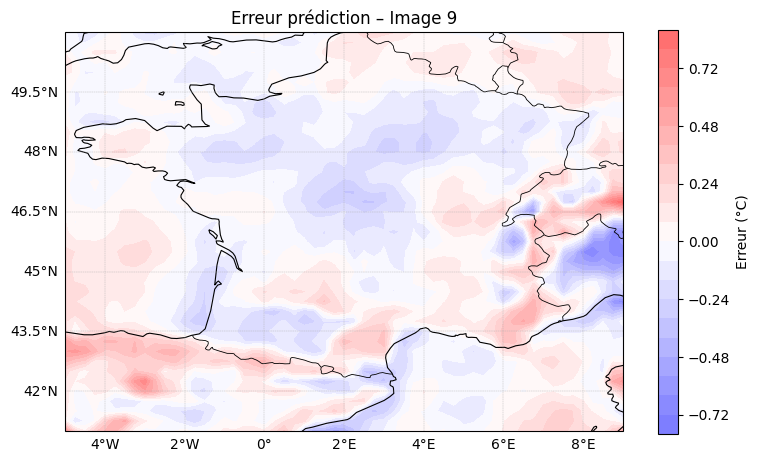

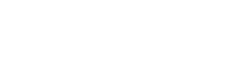

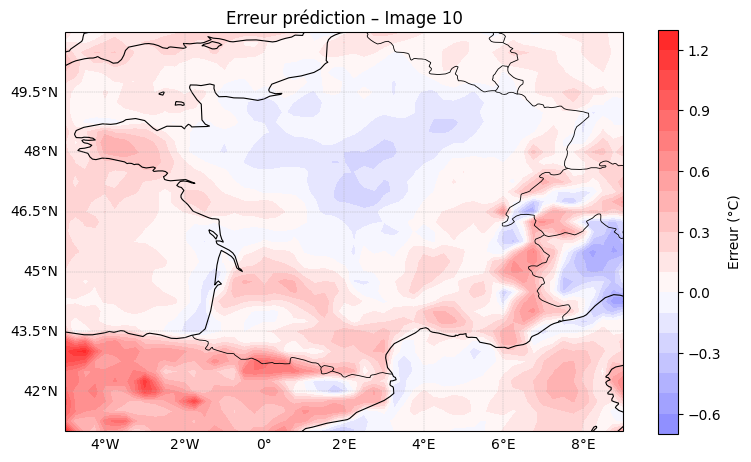

<Figure size 640x480 with 0 Axes>

In [ ]:
# 10 images d’erreur
errors = Y_pred[best_idx] - Y_test[best_idx]   # (10, H, W, 1)

# 5 lignes × 2 colonnes
rows, cols = 5, 2

plt.figure(figsize=(16, 30))

for i in range(10):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')  # important : sinon Cartopy se fait écraser

    # Appel direct à TA FONCTION
    plot_error_map(
        errors[i],
        lon,
        lat,
        title=f"Erreur prédiction – Image {i+1}"
    )

plt.tight_layout()
plt.show()



l'image 0 est regresséee


KeyboardInterrupt: 

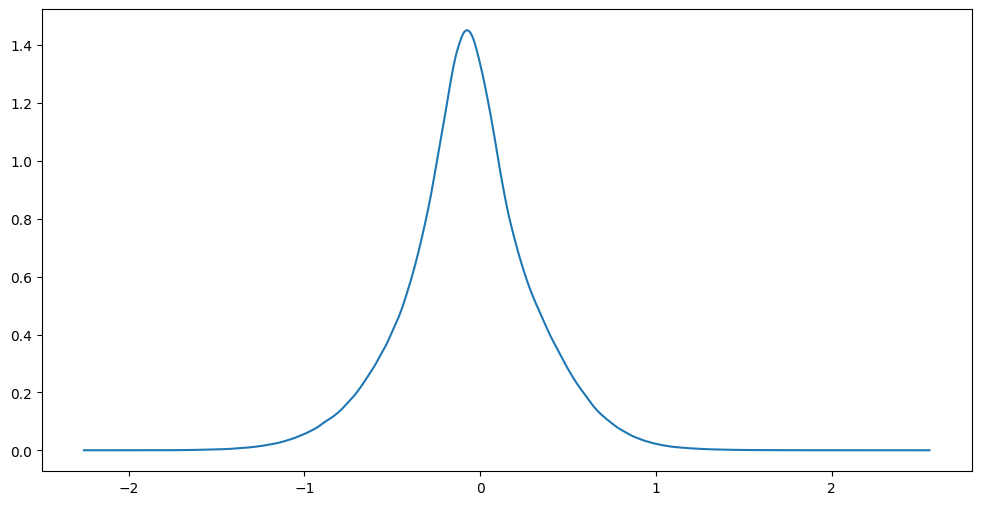

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Erreur absolue
error = Y_pred - Y_test  # shape (N, 10, H, W, 1)
error = error[..., 0]            # supprime canal → (N, 10, H, W)

plt.figure(figsize=(12, 6))

for t in range(10):  # pour les 10 images du sample

    # Erreurs de toutes les images à l'instant t : (N*H*W)
    err_t = error[:, t, :, :].reshape(-1)

    # KDE
    kde = gaussian_kde(err_t)
    x_vals = np.linspace(np.min(err_t), np.max(err_t), 750)  # erreur ≥ 0

    plt.plot(x_vals, kde(x_vals), label=f"Image {t+1}")
    print("l'image",t,"est regresséee")

plt.title("Distribution des erreurs absolues par image (KDE)")
plt.xlabel("Erreur absolue (°C)")
plt.ylabel("Densité")
plt.legend(title="Position temporelle")
plt.grid(True)
plt.show()


l'image 0 est regresséee
l'image 1 est regresséee
l'image 2 est regresséee
l'image 3 est regresséee
l'image 4 est regresséee
l'image 5 est regresséee
l'image 6 est regresséee
l'image 7 est regresséee
l'image 8 est regresséee
l'image 9 est regresséee


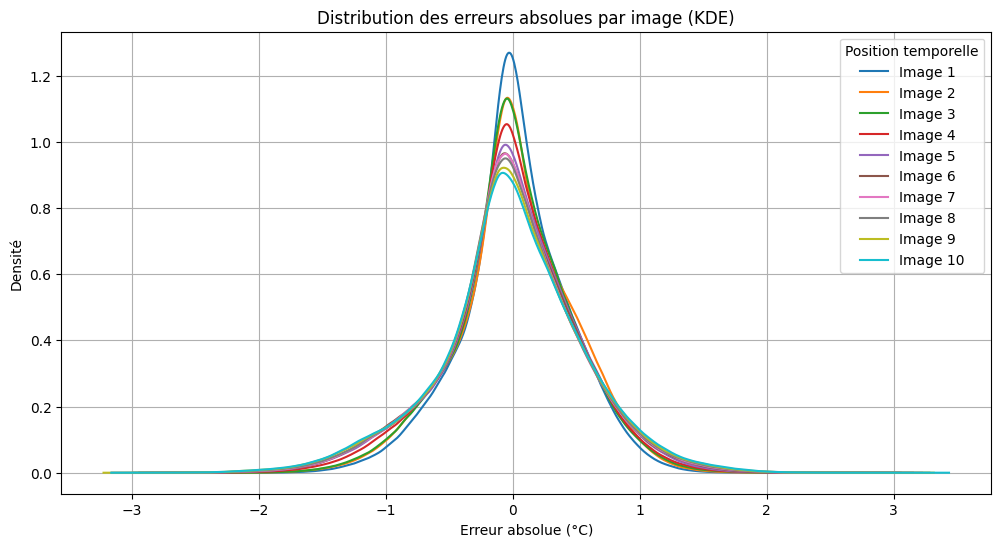

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Erreur absolue
error = Y_pred - Y_test  # shape (N, 10, H, W, 1)
error = error[..., 0]            # supprime canal → (N, 10, H, W)

plt.figure(figsize=(12, 6))

for t in range(10):  # pour les 10 images du sample

    # Erreurs de toutes les images à l'instant t : (N*H*W)
    err_t = error[:, t, :, :].reshape(-1)

    # KDE
    kde = gaussian_kde(err_t)
    x_vals = np.linspace(np.min(err_t), np.max(err_t), 750)  # erreur ≥ 0

    plt.plot(x_vals, kde(x_vals), label=f"Image {t+1}")
    print("l'image",t,"est regresséee")

plt.title("Distribution des erreurs absolues par image (KDE)")
plt.xlabel("Erreur absolue (°C)")
plt.ylabel("Densité")
plt.legend(title="Position temporelle")
plt.grid(True)
plt.show()


# Test differents losses

# MSE loss


In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import (
    Input,
    BatchNormalization,
    TimeDistributed,
    MaxPooling2D,
    Conv2DTranspose,
    Lambda,
    Conv2D,
    RepeatVector,  # On peut même le supprimer de l'import
    ConvLSTM2D
)
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.optimizers import Adam

def gradient_penalty(y_true, y_pred):
    dy_pred = y_pred[:, :, 1:, :, :] - y_pred[:, :, :-1, :, :]
    dx_pred = y_pred[:, :, :, 1:, :] - y_pred[:, :, :, :-1, :]

    return 0.05 * (tf.reduce_mean(tf.abs(dx_pred)) + tf.reduce_mean(tf.abs(dy_pred)))

def conv_block(x, filters):
    x = TimeDistributed(Conv2D(filters, (3,3), padding="same", activation="relu"))(x)
    x = TimeDistributed(Conv2D(filters, (3,3), padding="same", activation="relu"))(x)
    return x

def build_convlstm_model(input_shape=(6, 43, 57, 1), output_steps=2):
    """
    Construit un modèle Encoder-Decoder ConvLSTM.
    """
    inputs = Input(shape=input_shape)

    # --- ENCODER ---
    x = ConvLSTM2D(
        filters=32,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        activation='relu'
    )(inputs)
    x = BatchNormalization()(x)

    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    skip_32 = x

    x = ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        activation='relu'
    )(x)
    x = BatchNormalization()(x)

    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    skip_64 = x

    x = ConvLSTM2D(
    filters=96,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=True,
    activation='relu'
    )(x)
    x = BatchNormalization()(x)

    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = ConvLSTM2D(
        filters=128,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=False, # <-- Donne (Batch, 10, 14, 128)
        activation='relu'
    )(x)

    # --- PONT (Bridge) ---

    # LIGNE SUPPRIMÉE (incorrecte) :
    # x = RepeatVector(output_steps)(x)

    # CORRECTION : Utiliser Lambda pour expand_dims et tile
    # 1. tf.expand_dims(x, axis=1) -> (Batch, 1, 10, 14, 128)
    # 2. tf.tile(...) -> (Batch, 2, 10, 14, 128)
    x = Lambda(
        lambda t: tf.tile(tf.expand_dims(t, axis=1), [1, output_steps, 1, 1, 1])
    )(x)

    # --- DECODER ---
    # L'entrée est maintenant (Batch, 2, 10, 14, 128), ce qui est correct !
    x = ConvLSTM2D(
        filters=128,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True, # <-- Très important
        activation='relu',
        dropout=0.2,
        recurrent_dropout=0.2
    )(x)
    x = BatchNormalization()(x)

    x = conv_block(x, 128)

    # --- UPSAMPLE 1 : (5,7) → (10,14)
    x = TimeDistributed(Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'))(x)
    x = BatchNormalization()(x)

    # --- SKIP CONNECTION ---
    skip_64 = Lambda(lambda t: t[:, -output_steps:, :, :, :])(skip_64)
    x = tf.keras.layers.Concatenate(axis=-1)([x, skip_64])

    # Optionnel mais conseillé : petit conv_block
    x = conv_block(x, 64)

    # --- UPSAMPLE 2 : (10,14) → (20,28)
    x = TimeDistributed(Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'))(x)
    x = BatchNormalization()(x)

    # --- UPSAMPLE FINAL → (43,57)
    x = TimeDistributed(Lambda(lambda t: tf.image.resize(t, (43, 57))))(x)

    skip_32 = Lambda(lambda t: t[:, -output_steps:])(skip_32)
    skip_32 = TimeDistributed(Lambda(lambda t: tf.image.resize(t, (43, 57))))(skip_32)
    x = tf.keras.layers.Concatenate(axis=-1)([x, skip_32])
    x = conv_block(x, 32)

    x = TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'))(x)
    outputs = TimeDistributed(Conv2D(1, (1, 1), padding='same', activation='linear'))(x)

    model = Model(inputs, outputs)
    return model

# --- Configuration et Entraînement ---
model = build_convlstm_model() # Utiliser la nouvelle fonction

lr_schedule = CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=5,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-6
)

model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss="mse",
    metrics=['mae']
)
model.summary()




Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 6, 43, 57, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_10      │ (None, 6, 43, 57, │     38,144 │ input_layer_2[0]… │
│ (ConvLSTM2D)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 43, 57, │        128 │ conv_lstm2d_10[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_30 │ (None, 6, 21, 28, │          0 │ batch_normalizat… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_11      │ (None, 6, 21, 28, │    221,440 │ time_distributed… │
│ (ConvLSTM2D)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 21, 28, │        256 │ conv_lstm2d_11[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_31 │ (None, 6, 10, 14, │          0 │ batch_normalizat… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_12      │ (None, 6, 10, 14, │    553,344 │ time_distributed… │
│ (ConvLSTM2D)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 10, 14, │        384 │ conv_lstm2d_12[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_32 │ (None, 6, 5, 7,   │          0 │ batch_normalizat… │
│ (TimeDistributed)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_13      │ (None, 5, 7, 128) │  1,032,704 │ time_distributed… │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, 2, 5, 7,   │          0 │ conv_lstm2d_13[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_14      │ (None, 2, 5, 7,   │  1,180,160 │ lambda_10[0][0]   │
│ (ConvLSTM2D)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 5, 7,   │        512 │ conv_lstm2d_14[0… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_33 │ (None, 2, 5, 7,   │    147,584 │ batch_normalizat… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_34 │ (None, 2, 5, 7,   │    147,584 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_35 │ (None, 2, 10, 14, │     73,792 │ time_distributed

 Total params: 3,557,953 (13.57 MB)

 Trainable params: 3,557,121 (13.57 MB)

 Non-trainable params: 832 (3.25 KB)

In [ ]:
import tensorflow as tf
import numpy as np
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

# --- 1. CRÉATION DES PIPELINES DE DONNÉES (tf.data.Dataset) ---
BATCH_SIZE = 32 # Tirez parti de la puissance du GPU, ajustez si manque de VRAM

# Créer les datasets à partir de vos tableaux NumPy
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

# Préparer le pipeline d'entraînement : Mélange, Batch, Préfetche
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)) \
                             .batch(BATCH_SIZE) \
                             .prefetch(tf.data.AUTOTUNE)

# Préparer le pipeline de validation : Batch, Préfetche
val_dataset = val_dataset.batch(BATCH_SIZE) \
                         .prefetch(tf.data.AUTOTUNE)

print("Pipelines tf.data.Dataset créés avec succès.")


# --- 2. DÉFINITION DES CALLBACKS ---
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,          # Attend 15 époques de stagnation
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_convlstm_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# --- 3. ENTRAÎNEMENT DU MODÈLE ---
print("\nLancement de l'entraînement...")

history = model.fit(
    train_dataset,
    epochs=15, # Sera arrêté par EarlyStopping
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

print("\nEntraînement terminé. Le modèle optimal est sauvegardé.")

Pipelines tf.data.Dataset créés avec succès.

Lancement de l'entraînement...
Epoch 1/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.2220 - mae: 0.3522
Epoch 1: val_loss improved from inf to 0.66977, saving model to best_convlstm_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 133s 346ms/step - loss: 0.2218 - mae: 0.3520 - val_loss: 0.6698 - val_mae: 0.6474
Epoch 2/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.1037 - mae: 0.2431
Epoch 2: val_loss improved from 0.66977 to 0.21562, saving model to best_convlstm_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 62s 225ms/step - loss: 0.1037 - mae: 0.2431 - val_loss: 0.2156 - val_mae: 0.3619
Epoch 3/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.0773 - mae: 0.2099
Epoch 3: val_loss improved from 0.21562 to 0.08366, saving model to best_convlstm_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 61s 222ms/step - loss: 0.0773 - mae: 0.2099 - val_loss: 0.0837 - val_mae: 0.2210
Epoch 4/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0

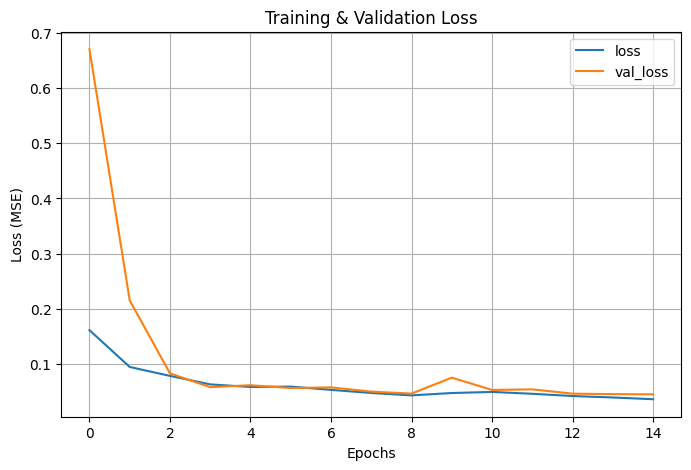

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
Y_pred = model.predict(X_test)  # forme (n_samples, 2, 43, 57, 1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step


In [ ]:
import numpy as np

# S'assurer que Y_test a la bonne shape
if Y_test.ndim == 4:
    Y_test = Y_test[..., np.newaxis]

# 1) erreur pixel par pixel
error = np.abs(Y_pred - Y_test)

# 2) moyenne par image
mean_error_per_output = np.mean(error, axis=(0, 2, 3, 4))
print("Erreur moyenne par image :", mean_error_per_output)

# 3) moyenne globale
global_mean_error = np.mean(mean_error_per_output)
print("Erreur moyenne globale :", global_mean_error)

Erreur moyenne par image : [0.13564073 0.16629411]
Erreur moyenne globale : 0.15096742


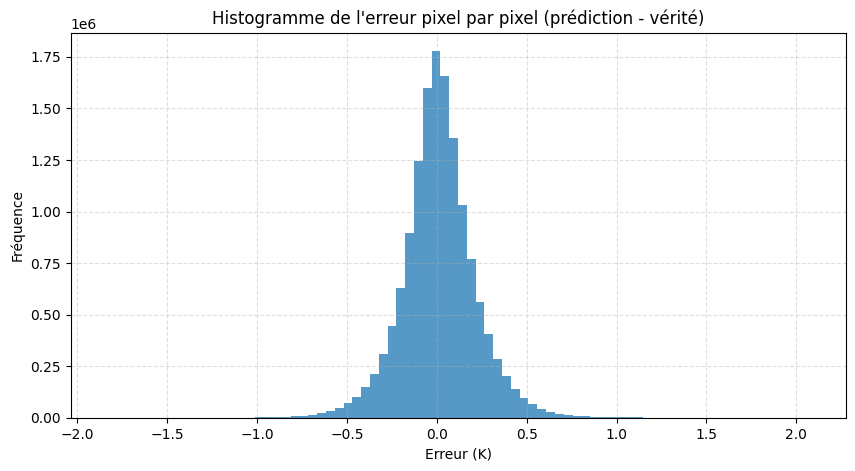

Erreur moyenne  : 0.012385873
Erreur absolue moyenne : 0.15096752
Erreur max      : 2.0773156
Erreur min      : -1.841079
MSE global     : 0.04201045


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------
# 1) Calcul de l'erreur pixel par pixel
# --------------------------------------------------------

# Y_pred : (N, 2, 43, 57, 1)
# Y_test : (N, 2, 43, 57, 1)
error = Y_pred - Y_test   # erreur signée (pos = trop chaud, neg = pas assez)

# On aplatit toutes les dimensions pour faire un histogramme global
error_flat = error.reshape(-1)

# --------------------------------------------------------
# 2) Trace de l'histogramme
# --------------------------------------------------------
plt.figure(figsize=(10,5))
plt.hist(error_flat, bins=80, alpha=0.75)
plt.title("Histogramme de l'erreur pixel par pixel (prédiction - vérité)")
plt.xlabel("Erreur (K)")
plt.ylabel("Fréquence")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# --------------------------------------------------------
# 3) Quelques statistiques utiles
# --------------------------------------------------------
print("Erreur moyenne  :", np.mean(error_flat))
print("Erreur absolue moyenne :", np.mean(np.abs(error_flat)))
print("Erreur max      :", np.max(error_flat))
print("Erreur min      :", np.min(error_flat))
print("MSE global     :", np.mean(error_flat**2))

# MAE loss

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import (
    Input,
    BatchNormalization,
    TimeDistributed,
    MaxPooling2D,
    Conv2DTranspose,
    Lambda,
    Conv2D,
    RepeatVector,  # On peut même le supprimer de l'import
    ConvLSTM2D
)
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.optimizers import Adam

def gradient_penalty(y_true, y_pred):
    dy_pred = y_pred[:, :, 1:, :, :] - y_pred[:, :, :-1, :, :]
    dx_pred = y_pred[:, :, :, 1:, :] - y_pred[:, :, :, :-1, :]

    return 0.05 * (tf.reduce_mean(tf.abs(dx_pred)) + tf.reduce_mean(tf.abs(dy_pred)))

def conv_block(x, filters):
    x = TimeDistributed(Conv2D(filters, (3,3), padding="same", activation="relu"))(x)
    x = TimeDistributed(Conv2D(filters, (3,3), padding="same", activation="relu"))(x)
    return x

def build_convlstm_model(input_shape=(6, 43, 57, 1), output_steps=2):
    """
    Construit un modèle Encoder-Decoder ConvLSTM.
    """
    inputs = Input(shape=input_shape)

    # --- ENCODER ---
    x = ConvLSTM2D(
        filters=32,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        activation='relu'
    )(inputs)
    x = BatchNormalization()(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    skip_32 = x
    x = ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        activation='relu'
    )(x)
    x = BatchNormalization()(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    skip_64 = x
    x = ConvLSTM2D(
    filters=96,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=True,
    activation='relu'
    )(x)
    x = BatchNormalization()(x)

    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = ConvLSTM2D(
        filters=128,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=False, # <-- Donne (Batch, 10, 14, 128)
        activation='relu'
    )(x)

    # --- PONT (Bridge) ---
    # LIGNE SUPPRIMÉE (incorrecte) :
    # x = RepeatVector(output_steps)(x)
    # CORRECTION : Utiliser Lambda pour expand_dims et tile
    # 1. tf.expand_dims(x, axis=1) -> (Batch, 1, 10, 14, 128)
    # 2. tf.tile(...) -> (Batch, 2, 10, 14, 128)
    x = Lambda(
        lambda t: tf.tile(tf.expand_dims(t, axis=1), [1, output_steps, 1, 1, 1])
    )(x)

    # --- DECODER ---
    # L'entrée est maintenant (Batch, 2, 10, 14, 128), ce qui est correct !
    x = ConvLSTM2D(
        filters=128,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True, # <-- Très important
        activation='relu',
        dropout=0.2,
        recurrent_dropout=0.2
    )(x)
    x = BatchNormalization()(x)
    x = conv_block(x, 128)

    # --- UPSAMPLE 1 : (5,7) → (10,14)
    x = TimeDistributed(Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'))(x)
    x = BatchNormalization()(x)

    # --- SKIP CONNECTION ---
    skip_64 = Lambda(lambda t: t[:, -output_steps:, :, :, :])(skip_64)
    x = tf.keras.layers.Concatenate(axis=-1)([x, skip_64])

    # Optionnel mais conseillé : petit conv_block
    x = conv_block(x, 64)
    # --- UPSAMPLE 2 : (10,14) → (20,28)
    x = TimeDistributed(Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'))(x)
    x = BatchNormalization()(x)
    # --- UPSAMPLE FINAL → (43,57)
    x = TimeDistributed(Lambda(lambda t: tf.image.resize(t, (43, 57))))(x)

    skip_32 = Lambda(lambda t: t[:, -output_steps:])(skip_32)
    skip_32 = TimeDistributed(Lambda(lambda t: tf.image.resize(t, (43, 57))))(skip_32)
    x = tf.keras.layers.Concatenate(axis=-1)([x, skip_32])
    x = conv_block(x, 32)
    x = TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'))(x)
    outputs = TimeDistributed(Conv2D(1, (1, 1), padding='same', activation='linear'))(x)

    model = Model(inputs, outputs)
    return model

# --- Configuration et Entraînement ---
model = build_convlstm_model() # Utiliser la nouvelle fonction

lr_schedule = CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=5,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-6
)

model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss="mae"
)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 6, 43, 57, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_15      │ (None, 6, 43, 57, │     38,144 │ input_layer_3[0]… │
│ (ConvLSTM2D)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 43, 57, │        128 │ conv_lstm2d_15[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_45 │ (None, 6, 21, 28, │          0 │ batch_normalizat… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_16      │ (None, 6, 21, 28, │    221,440 │ time_distributed… │
│ (ConvLSTM2D)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 21, 28, │        256 │ conv_lstm2d_16[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_46 │ (None, 6, 10, 14, │          0 │ batch_normalizat… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_17      │ (None, 6, 10, 14, │    553,344 │ time_distributed… │
│ (ConvLSTM2D)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 10, 14, │        384 │ conv_lstm2d_17[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_47 │ (None, 6, 5, 7,   │          0 │ batch_normalizat… │
│ (TimeDistributed)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_18      │ (None, 5, 7, 128) │  1,032,704 │ time_distributed… │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_15 (Lambda)  │ (None, 2, 5, 7,   │          0 │ conv_lstm2d_18[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_19      │ (None, 2, 5, 7,   │  1,180,160 │ lambda_15[0][0]   │
│ (ConvLSTM2D)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 5, 7,   │        512 │ conv_lstm2d_19[0… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_48 │ (None, 2, 5, 7,   │    147,584 │ batch_normalizat… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_49 │ (None, 2, 5, 7,   │    147,584 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_50 │ (None, 2, 10, 14, │     73,792 │ time_distributed

 Total params: 3,557,953 (13.57 MB)

 Trainable params: 3,557,121 (13.57 MB)

 Non-trainable params: 832 (3.25 KB)

In [ ]:
import tensorflow as tf
import numpy as np
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

# --- 1. CRÉATION DES PIPELINES DE DONNÉES (tf.data.Dataset) ---
BATCH_SIZE = 32 # Tirez parti de la puissance du GPU, ajustez si manque de VRAM

# Créer les datasets à partir de vos tableaux NumPy
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

# Préparer le pipeline d'entraînement : Mélange, Batch, Préfetche
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)) \
                             .batch(BATCH_SIZE) \
                             .prefetch(tf.data.AUTOTUNE)

# Préparer le pipeline de validation : Batch, Préfetche
val_dataset = val_dataset.batch(BATCH_SIZE) \
                         .prefetch(tf.data.AUTOTUNE)

print("Pipelines tf.data.Dataset créés avec succès.")


# --- 2. DÉFINITION DES CALLBACKS ---
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,          # Attend 15 époques de stagnation
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_convlstm_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# --- 3. ENTRAÎNEMENT DU MODÈLE ---
print("\nLancement de l'entraînement...")

history = model.fit(
    train_dataset,
    epochs=15, # Sera arrêté par EarlyStopping
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

print("\nEntraînement terminé. Le modèle optimal est sauvegardé.")

Pipelines tf.data.Dataset créés avec succès.

Lancement de l'entraînement...
Epoch 1/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 0.3596
Epoch 1: val_loss improved from inf to 0.66933, saving model to best_convlstm_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 122s 320ms/step - loss: 0.3593 - val_loss: 0.6693
Epoch 2/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.2266
Epoch 2: val_loss improved from 0.66933 to 0.39943, saving model to best_convlstm_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 62s 223ms/step - loss: 0.2266 - val_loss: 0.3994
Epoch 3/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.1949
Epoch 3: val_loss improved from 0.39943 to 0.18913, saving model to best_convlstm_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 61s 221ms/step - loss: 0.1949 - val_loss: 0.1891
Epoch 4/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.1858
Epoch 4: val_loss improved from 0.18913 to 0.17271, saving model to best_convlstm_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 63s 230ms/s

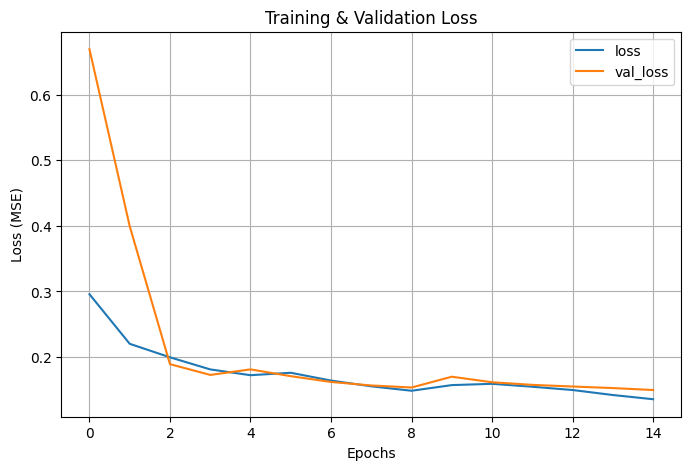

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
Y_pred = model.predict(X_test)  # forme (n_samples, 2, 43, 57, 1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step


In [ ]:
import numpy as np

# S'assurer que Y_test a la bonne shape
if Y_test.ndim == 4:
    Y_test = Y_test[..., np.newaxis]

# 1) erreur pixel par pixel
error = np.abs(Y_pred - Y_test)

# 2) moyenne par image
mean_error_per_output = np.mean(error, axis=(0, 2, 3, 4))
print("Erreur moyenne par image :", mean_error_per_output)

# 3) moyenne globale
global_mean_error = np.mean(mean_error_per_output)
print("Erreur moyenne globale :", global_mean_error)

Erreur moyenne par image : [0.12757438 0.15999582]
Erreur moyenne globale : 0.1437851


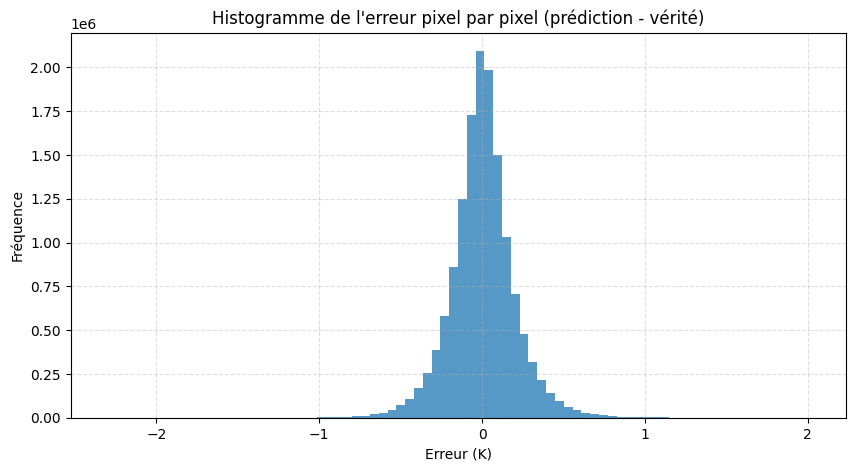

Erreur moyenne  : 0.004251594
Erreur absolue moyenne : 0.14378527
Erreur max      : 2.0154855
Erreur min      : -2.3113084
MSE global     : 0.039238304


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------
# 1) Calcul de l'erreur pixel par pixel
# --------------------------------------------------------

# Y_pred : (N, 2, 43, 57, 1)
# Y_test : (N, 2, 43, 57, 1)
error = Y_pred - Y_test   # erreur signée (pos = trop chaud, neg = pas assez)

# On aplatit toutes les dimensions pour faire un histogramme global
error_flat = error.reshape(-1)

# --------------------------------------------------------
# 2) Trace de l'histogramme
# --------------------------------------------------------
plt.figure(figsize=(10,5))
plt.hist(error_flat, bins=80, alpha=0.75)
plt.title("Histogramme de l'erreur pixel par pixel (prédiction - vérité)")
plt.xlabel("Erreur (K)")
plt.ylabel("Fréquence")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# --------------------------------------------------------
# 3) Quelques statistiques utiles
# --------------------------------------------------------
print("Erreur moyenne  :", np.mean(error_flat))
print("Erreur absolue moyenne :", np.mean(np.abs(error_flat)))
print("Erreur max      :", np.max(error_flat))
print("Erreur min      :", np.min(error_flat))
print("MSE global     :", np.mean(error_flat**2))

# SSIM + MSE loss

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import (
    Input,
    BatchNormalization,
    TimeDistributed,
    MaxPooling2D,
    Conv2DTranspose,
    Lambda,
    Conv2D,
    RepeatVector,  # On peut même le supprimer de l'import
    ConvLSTM2D
)
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.optimizers import Adam

def gradient_penalty(y_true, y_pred):
    dy_pred = y_pred[:, :, 1:, :, :] - y_pred[:, :, :-1, :, :]
    dx_pred = y_pred[:, :, :, 1:, :] - y_pred[:, :, :, :-1, :]

    return 0.05 * (tf.reduce_mean(tf.abs(dx_pred)) + tf.reduce_mean(tf.abs(dy_pred)))

def ssim_loss(y_true, y_pred):
    # reshape en 4D: (batch*time, H, W, C)
    b, t, h, w, c = tf.shape(y_true)[0], tf.shape(y_true)[1], tf.shape(y_true)[2], tf.shape(y_true)[3], tf.shape(y_true)[4]

    y_true_4d = tf.reshape(y_true, (b*t, h, w, c))
    y_pred_4d = tf.reshape(y_pred, (b*t, h, w, c))

    # SSIM → valeurs entre -1 et 1
    ssim_val = tf.image.ssim(y_true_4d, y_pred_4d, max_val=1.0)  # suppose tes données normalisées [0,1] ou [-1,1]

    # Loss = 1 - SSIM
    return 1 - tf.reduce_mean(ssim_val)

def combined_loss(y_true, y_pred, coef=0.1):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim = ssim_loss(y_true, y_pred)
    return mse + coef * ssim

def conv_block(x, filters):
    x = TimeDistributed(Conv2D(filters, (3,3), padding="same", activation="relu"))(x)
    x = TimeDistributed(Conv2D(filters, (3,3), padding="same", activation="relu"))(x)
    return x

def build_convlstm_model(input_shape=(6, 43, 57, 1), output_steps=2):
    """
    Construit un modèle Encoder-Decoder ConvLSTM.
    """
    inputs = Input(shape=input_shape)

    # --- ENCODER ---
    x = ConvLSTM2D(
        filters=32,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        activation='relu'
    )(inputs)
    x = BatchNormalization()(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    skip_32 = x
    x = ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        activation='relu'
    )(x)
    x = BatchNormalization()(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    skip_64 = x
    x = ConvLSTM2D(
    filters=96,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=True,
    activation='relu'
    )(x)
    x = BatchNormalization()(x)

    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = ConvLSTM2D(
        filters=128,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=False, # <-- Donne (Batch, 10, 14, 128)
        activation='relu'
    )(x)

    # --- PONT (Bridge) ---
    # LIGNE SUPPRIMÉE (incorrecte) :
    # x = RepeatVector(output_steps)(x)
    # CORRECTION : Utiliser Lambda pour expand_dims et tile
    # 1. tf.expand_dims(x, axis=1) -> (Batch, 1, 10, 14, 128)
    # 2. tf.tile(...) -> (Batch, 2, 10, 14, 128)
    x = Lambda(
        lambda t: tf.tile(tf.expand_dims(t, axis=1), [1, output_steps, 1, 1, 1])
    )(x)

    # --- DECODER ---
    # L'entrée est maintenant (Batch, 2, 10, 14, 128), ce qui est correct !
    x = ConvLSTM2D(
        filters=128,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True, # <-- Très important
        activation='relu',
        dropout=0.2,
        recurrent_dropout=0.2
    )(x)
    x = BatchNormalization()(x)
    x = conv_block(x, 128)

    # --- UPSAMPLE 1 : (5,7) → (10,14)
    x = TimeDistributed(Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'))(x)
    x = BatchNormalization()(x)

    # --- SKIP CONNECTION ---
    skip_64 = Lambda(lambda t: t[:, -output_steps:, :, :, :])(skip_64)
    x = tf.keras.layers.Concatenate(axis=-1)([x, skip_64])

    # Optionnel mais conseillé : petit conv_block
    x = conv_block(x, 64)
    # --- UPSAMPLE 2 : (10,14) → (20,28)
    x = TimeDistributed(Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'))(x)
    x = BatchNormalization()(x)
    # --- UPSAMPLE FINAL → (43,57)
    x = TimeDistributed(Lambda(lambda t: tf.image.resize(t, (43, 57))))(x)

    skip_32 = Lambda(lambda t: t[:, -output_steps:])(skip_32)
    skip_32 = TimeDistributed(Lambda(lambda t: tf.image.resize(t, (43, 57))))(skip_32)
    x = tf.keras.layers.Concatenate(axis=-1)([x, skip_32])
    x = conv_block(x, 32)
    x = TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'))(x)
    outputs = TimeDistributed(Conv2D(1, (1, 1), padding='same', activation='linear'))(x)

    model = Model(inputs, outputs)
    return model

# --- Configuration et Entraînement ---
model = build_convlstm_model() # Utiliser la nouvelle fonction

lr_schedule = CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=5,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-6
)

model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=combined_loss,
    metrics=['mae']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 6, 43, 57, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 6, 43, 57, │     38,144 │ input_layer[0][0] │
│ (ConvLSTM2D)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 6, 43, 57, │        128 │ conv_lstm2d[0][0] │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 6, 21, 28, │          0 │ batch_normalizat… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 6, 21, 28, │    221,440 │ time_distributed… │
│ (ConvLSTM2D)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 21, 28, │        256 │ conv_lstm2d_1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 6, 10, 14, │          0 │ batch_normalizat… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_2       │ (None, 6, 10, 14, │    553,344 │ time_distributed… │
│ (ConvLSTM2D)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 10, 14, │        384 │ conv_lstm2d_2[0]… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 6, 5, 7,   │          0 │ batch_normalizat… │
│ (TimeDistributed)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_3       │ (None, 5, 7, 128) │  1,032,704 │ time_distributed… │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 2, 5, 7,   │          0 │ conv_lstm2d_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_4       │ (None, 2, 5, 7,   │  1,180,160 │ lambda[0][0]      │
│ (ConvLSTM2D)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 5, 7,   │        512 │ conv_lstm2d_4[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 2, 5, 7,   │    147,584 │ batch_normalizat… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 2, 5, 7,   │    147,584 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 2, 10, 14, │     73,792 │ time_distributed

 Total params: 3,557,953 (13.57 MB)

 Trainable params: 3,557,121 (13.57 MB)

 Non-trainable params: 832 (3.25 KB)

In [ ]:
import tensorflow as tf
import numpy as np
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

# --- 1. CRÉATION DES PIPELINES DE DONNÉES (tf.data.Dataset) ---
BATCH_SIZE = 32 # Tirez parti de la puissance du GPU, ajustez si manque de VRAM

# Créer les datasets à partir de vos tableaux NumPy
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

# Préparer le pipeline d'entraînement : Mélange, Batch, Préfetche
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)) \
                             .batch(BATCH_SIZE) \
                             .prefetch(tf.data.AUTOTUNE)

# Préparer le pipeline de validation : Batch, Préfetche
val_dataset = val_dataset.batch(BATCH_SIZE) \
                         .prefetch(tf.data.AUTOTUNE)

print("Pipelines tf.data.Dataset créés avec succès.")


# --- 2. DÉFINITION DES CALLBACKS ---
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,          # Attend 15 époques de stagnation
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_convlstm_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# --- 3. ENTRAÎNEMENT DU MODÈLE ---
print("\nLancement de l'entraînement...")

history = model.fit(
    train_dataset,
    epochs=15, # Sera arrêté par EarlyStopping
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

print("\nEntraînement terminé. Le modèle optimal est sauvegardé.")

Pipelines tf.data.Dataset créés avec succès.

Lancement de l'entraînement...
Epoch 1/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.2970 - mae: 0.3551
Epoch 1: val_loss improved from inf to 0.79620, saving model to best_convlstm_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 131s 337ms/step - loss: 0.2967 - mae: 0.3549 - val_loss: 0.7962 - val_mae: 0.6625
Epoch 2/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.1363 - mae: 0.2248
Epoch 2: val_loss improved from 0.79620 to 0.33734, saving model to best_convlstm_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 62s 224ms/step - loss: 0.1363 - mae: 0.2248 - val_loss: 0.3373 - val_mae: 0.4048
Epoch 3/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.1113 - mae: 0.1972
Epoch 3: val_loss improved from 0.33734 to 0.12702, saving model to best_convlstm_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 61s 222ms/step - loss: 0.1113 - mae: 0.1972 - val_loss: 0.1270 - val_mae: 0.2212
Epoch 4/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.1

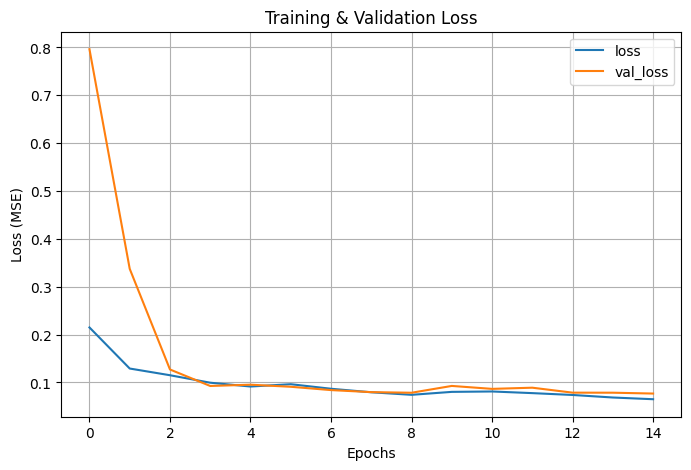

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
Y_pred = model.predict(X_test)  # forme (n_samples, 2, 43, 57, 1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step


In [ ]:
import numpy as np

# S'assurer que Y_test a la bonne shape
if Y_test.ndim == 4:
    Y_test = Y_test[..., np.newaxis]

# 1) erreur pixel par pixel
error = np.abs(Y_pred - Y_test)

# 2) moyenne par image
mean_error_per_output = np.mean(error, axis=(0, 2, 3, 4))
print("Erreur moyenne par image :", mean_error_per_output)

# 3) moyenne globale
global_mean_error = np.mean(mean_error_per_output)
print("Erreur moyenne globale :", global_mean_error)

Erreur moyenne par image : [0.13235219 0.16300702]
Erreur moyenne globale : 0.1476796
